# Imports and Downloads

### Slow

In [ ]:
# Required environment installations
!pip install torch_geometric
# Clone repo code
!git clone --branch baselineCe https://github.com/Graph-Classification-Noisy-Label/hackaton.git
%cd hackaton/
# Obtain dataset
!gdown --folder https://drive.google.com/drive/folders/1_np6HKijJ_0vaNoXCrtVo7z79vuCMCO_ -O datasets

# Import libraries
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch.utils.data import random_split, Dataset

# Load utility functions from cloned repository
from src.loadData import GraphDataset # type: ignore
from src.utils import set_seed        # type: ignore
# from src.models import GNN            # type: ignore
import argparse

# Set the random seed
set_seed()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
Cloning into 'hackaton'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 81 (delta 4), reused 4 (delta 4), pack-reused 70 (from 1)
Receiving objects: 100% (81/81), 105.83 MiB | 53.23 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/hackaton
Retrieving folder contents
Retrieving folder 1Sf2vFZ8HGJUZhEa1of1Pe8uIBVE1IrH1 A
Processing file 1mhGVyB-PIFj09tmrYEXBaCqzz61y4BHr test.json.gz
Processing file 1l5I_20yv0vksMc0j3-eRTk4st4Ca2Jmk train.json.gz
Retrieving folder 1xzJxUlNMTf7IrXoYYddS_gRgmr4eW_Xi B
Processing file 1W-aYAxVByTL9bnDS7DZjoM59lA13aq2X test.json.gz
Processing file 1pBANOzDYS8MoTgCW7REXl52U5kyEvDmi train.json.gz
Retrieving folder 13XmZlRbEaUPsuBMIDA7pgEDMoGS6FbFc C
Processing file 1CkM9xcD37LcJmzl6LEM_kMa4lrDBXo5

### Fast (Model definitions)

In [232]:
import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GINEConv as PyG_GINEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.utils import degree

import math

import torch
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GINEConv as PyG_GINEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.utils import degree

import math


### GIN convolution along the graph structure
class GINConv(MessagePassing):
    def __init__(self, emb_dim):
        '''
            emb_dim (int): node embedding dimensionality
        '''

        super(GINConv, self).__init__(aggr = "add")

        self.mlp = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, emb_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]))

        self.edge_encoder = torch.nn.Linear(7, emb_dim)

    def forward(self, x, edge_index, edge_attr):
        edge_embedding = self.edge_encoder(edge_attr)
        out = self.mlp((1 + self.eps) *x + self.propagate(edge_index, x=x, edge_attr=edge_embedding))

        return out

    def message(self, x_j, edge_attr):
        return F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

### GCN convolution along the graph structure
class GCNConv(MessagePassing):
    def __init__(self, emb_dim):
        super(GCNConv, self).__init__(aggr='add')

        self.linear = torch.nn.Linear(emb_dim, emb_dim)
        self.root_emb = torch.nn.Embedding(1, emb_dim)
        self.edge_encoder = torch.nn.Linear(7, emb_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.linear(x)
        edge_embedding = self.edge_encoder(edge_attr)

        row, col = edge_index

        #edge_weight = torch.ones((edge_index.size(1), ), device=edge_index.device)
        deg = degree(row, x.size(0), dtype = x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return self.propagate(edge_index, x=x, edge_attr = edge_embedding, norm=norm) + F.relu(x + self.root_emb.weight) * 1./deg.view(-1,1)

    def message(self, x_j, edge_attr, norm):
        return norm.view(-1, 1) * F.relu(x_j + edge_attr)

    def update(self, aggr_out):
        return aggr_out

class GINEConvCustom(torch.nn.Module):
    """
    GINEConv + a 7→emb_dim edge encoder.
    """
    def __init__(self, emb_dim):
        super().__init__()
        # 1) embed your 7-dim edge_attr → emb_dim
        self.edge_encoder = torch.nn.Linear(7, emb_dim)
        # 2) the MLP that the original GINE paper uses
        mlp = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 2*emb_dim),
            torch.nn.BatchNorm1d(2*emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(2*emb_dim, emb_dim),
        )
        # 3) build the actual GINE layer
        self.conv = PyG_GINEConv(nn=mlp, train_eps=True)

    def forward(self, x, edge_index, edge_attr):
        # encode edge_attr → same dim as x
        e = self.edge_encoder(edge_attr)
        # delegate to PyG’s GINEConv
        return self.conv(x, edge_index, e)


### GNN to generate node embedding
class GNN_node(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, emb_dim, drop_ratio = 0.5, JK = "last", residual = False, gnn_type = 'gin'):
        '''
            emb_dim (int): node embedding dimensionality
            num_layer (int): number of GNN message passing layers

        '''

        super(GNN_node, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.node_encoder = torch.nn.Embedding(1, emb_dim) # uniform input node embedding

        ###List of GNNs
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(num_layer):
            if gnn_type == 'gin':
                self.convs.append(GINConv(emb_dim))
            elif gnn_type == 'gcn':
                self.convs.append(GCNConv(emb_dim))
            elif gnn_type == 'gine':
                self.convs.append(GINEConvCustom(emb_dim))
            else:
                raise ValueError('Undefined GNN type called {}'.format(gnn_type))

            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

    def forward(self, batched_data):
        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch


        ### computing input node embedding

        h_list = [self.node_encoder(x)]
        for layer in range(self.num_layer):

            h = self.convs[layer](h_list[layer], edge_index, edge_attr)
            h = self.batch_norms[layer](h)

            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)

            if self.residual:
                h += h_list[layer]

            h_list.append(h)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]

        return node_representation

### Virtual GNN to generate node embedding
class GNN_node_Virtualnode(torch.nn.Module):
    """
    Output:
        node representations
    """
    def __init__(self, num_layer, emb_dim, drop_ratio = 0.5, JK = "last", residual = False, gnn_type = 'gin'):
        '''
            emb_dim (int): node embedding dimensionality
        '''

        super(GNN_node_Virtualnode, self).__init__()
        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        ### add residual connection or not
        self.residual = residual

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        self.node_encoder = torch.nn.Embedding(1, emb_dim) # uniform input node embedding

        ### set the initial virtual node embedding to 0.
        self.virtualnode_embedding = torch.nn.Embedding(1, emb_dim)
        torch.nn.init.constant_(self.virtualnode_embedding.weight.data, 0)

        ### List of GNNs
        self.convs = torch.nn.ModuleList()
        ### batch norms applied to node embeddings
        self.batch_norms = torch.nn.ModuleList()

        ### List of MLPs to transform virtual node at every layer
        self.mlp_virtualnode_list = torch.nn.ModuleList()

        for layer in range(num_layer):
            if gnn_type == 'gin':
                self.convs.append(GINConv(emb_dim))
            elif gnn_type == 'gcn':
                self.convs.append(GCNConv(emb_dim))
            elif gnn_type == 'gine':
                self.convs.append(GINEConvCustom(emb_dim))
            else:
                raise ValueError('Undefined GNN type called {}'.format(gnn_type))

            self.batch_norms.append(torch.nn.BatchNorm1d(emb_dim))

        for layer in range(num_layer - 1):
            self.mlp_virtualnode_list.append(torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), \
                                                    torch.nn.Linear(2*emb_dim, emb_dim), torch.nn.BatchNorm1d(emb_dim), torch.nn.ReLU()))


    def forward(self, batched_data):

        x, edge_index, edge_attr, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch

        ### virtual node embeddings for graphs
        virtualnode_embedding = self.virtualnode_embedding(torch.zeros(batch[-1].item() + 1).to(edge_index.dtype).to(edge_index.device))

        h_list = [self.node_encoder(x)]
        for layer in range(self.num_layer):
            ### add message from virtual nodes to graph nodes
            h_list[layer] = h_list[layer] + virtualnode_embedding[batch]

            ### Message passing among graph nodes
            h = self.convs[layer](h_list[layer], edge_index, edge_attr)

            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.drop_ratio, training = self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)

            if self.residual:
                h = h + h_list[layer]

            h_list.append(h)

            ### update the virtual nodes
            if layer < self.num_layer - 1:
                ### add message from graph nodes to virtual nodes
                virtualnode_embedding_temp = global_add_pool(h_list[layer], batch) + virtualnode_embedding
                ### transform virtual nodes using MLP

                if self.residual:
                    virtualnode_embedding = virtualnode_embedding + F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training = self.training)
                else:
                    virtualnode_embedding = F.dropout(self.mlp_virtualnode_list[layer](virtualnode_embedding_temp), self.drop_ratio, training = self.training)

        ### Different implementations of Jk-concat
        if self.JK == "last":
            node_representation = h_list[-1]
        elif self.JK == "sum":
            node_representation = 0
            for layer in range(self.num_layer + 1):
                node_representation += h_list[layer]

        return node_representation


import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool, GlobalAttention, Set2Set
import torch.nn.functional as F
from torch_geometric.nn.inits import uniform

class GNN(torch.nn.Module):

    def __init__(self, num_class, num_layer = 5, emb_dim = 300,
                    gnn_type = 'gin', virtual_node = True, residual = False, drop_ratio = 0.5, JK = "last", graph_pooling = None):
        '''
            num_tasks (int): number of labels to be predicted
            virtual_node (bool): whether to add virtual node or not
        '''

        super(GNN, self).__init__()

        self.num_layer = num_layer
        self.drop_ratio = drop_ratio
        self.JK = JK
        self.emb_dim = emb_dim
        self.num_class = num_class
        self.graph_pooling = graph_pooling

        if self.num_layer < 2:
            raise ValueError("Number of GNN layers must be greater than 1.")

        ### GNN to generate node embeddings
        if virtual_node:
            self.gnn_node = GNN_node_Virtualnode(num_layer, emb_dim, JK = JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)
        else:
            self.gnn_node = GNN_node(num_layer, emb_dim, JK = JK, drop_ratio = drop_ratio, residual = residual, gnn_type = gnn_type)


        ### Pooling function to generate whole-graph embeddings
        if self.graph_pooling == "sum":
            self.pool = global_add_pool
        elif self.graph_pooling == "mean":
            self.pool = global_mean_pool
        elif self.graph_pooling == "max":
            self.pool = global_max_pool
        elif self.graph_pooling == "attention":
            self.pool = GlobalAttention(gate_nn = torch.nn.Sequential(torch.nn.Linear(emb_dim, 2*emb_dim), torch.nn.BatchNorm1d(2*emb_dim), torch.nn.ReLU(), torch.nn.Linear(2*emb_dim, 1)))
        elif self.graph_pooling == "set2set":
            self.pool = Set2Set(emb_dim, processing_steps = 2)
        else:
            raise ValueError("Invalid graph pooling type.")

        if graph_pooling == "set2set":
            self.graph_pred_linear = torch.nn.Linear(2*self.emb_dim, self.num_class)
        else:
            self.graph_pred_linear = torch.nn.Linear(self.emb_dim, self.num_class)

    def forward(self, batched_data):
        h_node = self.gnn_node(batched_data)

        h_graph = self.pool(h_node, batched_data.batch)

        return self.graph_pred_linear(h_graph)




class EnsembleGNN(nn.Module):
    def __init__(self, models: list[nn.Module], weights: list[float]):
        """
        models: lista di modelli nn.Module (es. [model1, model2, ...])
        weights: lista di float, stessa lunghezza di models, che sommano a 1.0
        """
        super().__init__()
        assert len(models) == len(weights), "Deve esserci un peso per ciascun modello"
        assert abs(sum(weights) - 1.0) < 1e-6, "I pesi devono sommare a 1"
        # Registra i modelli in un ModuleList, così PyTorch li scopre tutti
        self.models = nn.ModuleList(models)
        # I pesi non sono parametri, ma li memorizziamo qui
        #self.register_buffer('weights', torch.tensor(weights, dtype=torch.float32))
        init_raw = torch.tensor(weights, dtype=torch.float32)
        self.raw_weights = nn.Parameter(init_raw)

    def forward(self, data):
        # update model importance weights
        normalized_weights = F.softmax(self.raw_weights, dim=0)
        # Calcola le logit di ogni modello
        logits_list = [m(data) for m in self.models]  # ognuno [B, C]
        # Esegui la somma pesata
        ensembled = sum(w * l for w, l in zip(self.raw_weights, logits_list))
        return ensembled


# Useful functions definitions

## Load and inspect data

In [254]:
def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

def inspect(dataset):
  # 1. Basic info
  print(f"Dataset class: {dataset.__class__.__name__}")
  print(f"Number of graphs: {len(dataset)}")
  print(f"Available attributes: {dataset.__dict__.keys()}")

  # 2. Look at the first example
  data0 = dataset[0]        # indexing invokes your `add_zeros` transform, too
  print(data0)                   # prints a summary: nodes, edges, features, labels

  # 3. Inspect its tensors
  print("  • num_nodes:",    data0.num_nodes)
  print("  • num_edges:",    data0.num_edges)
  print("  • x.shape:",      None if data0.x is None else data0.x.shape)
  print("  • edge_index:",   data0.edge_index.shape, data0.edge_index[:, :10])
  print("  • y (labels):",   getattr(data0, 'y', None))

  # 4. List the fields on a Data object
  print("Data fields:", data0.keys)   # e.g. ['x', 'edge_index', 'y', ...]

  # 5. Examine distribution of graph sizes
  num_nodes = [d.num_nodes for d in dataset]
  num_edges = [d.num_edges for d in dataset]
  print(f"Node counts: min {min(num_nodes)}, max {max(num_nodes)}, mean {sum(num_nodes)/len(num_nodes):.1f}")
  print(f"Edge counts: min {min(num_edges)}, max {max(num_edges)}, mean {sum(num_edges)/len(num_edges):.1f}")

  # 6. (Optional) Batch a few graphs
  from torch_geometric.loader import DataLoader
  loader = DataLoader(dataset, batch_size=4, shuffle=True)
  batch = next(iter(loader))
  print(batch)   # shows combined batch with .batch vector, cumulative sizes, etc.


class IndexedDataset(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset
    def __len__(self):
        return len(self.base)
    def __getitem__(self, ix):
        data = self.base[ix]
        # attach a tensor of the global index
        data.idx = torch.tensor(ix, dtype=torch.long)
        return data

## Evaluation and plotting

In [255]:
def evaluate(data_loader, model, device, calculate_accuracy=False):
    """
      Evaluate GNN on test set
    """

    # Set model to evaluation mode (disables dropout, batch-norm, etc.)
    model.eval()
    correct, total, total_loss = 0, 0, 0
    predictions = []
    criterion = torch.nn.CrossEntropyLoss() # Fixed CE loss as we want real performance
    with torch.no_grad():
        # Iterate trough all test set using tqdm for visualization
        for data in tqdm(data_loader, desc="Iterating eval graphs", unit="batch"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            if calculate_accuracy:
                correct += (pred == data.y).sum().item()
                total += data.y.size(0)
                total_loss += criterion(output, data.y).item()
            else:
                predictions.extend(pred.cpu().numpy())

    if calculate_accuracy:
        accuracy = correct / total
        return  total_loss / len(data_loader), accuracy
    return predictions

def save_predictions(predictions, test_path):
    script_dir = os.getcwd()
    submission_folder = os.path.join(script_dir, "submission")
    test_dir_name = os.path.basename(os.path.dirname(test_path))

    os.makedirs(submission_folder, exist_ok=True)

    output_csv_path = os.path.join(submission_folder, f"testset_{test_dir_name}.csv")

    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })

    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

def plot_training_progress(train_losses, train_accuracies, output_dir):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(9, 3))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')

    # Save plots in the current directory
    os.makedirs(output_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_progress.png"))
    plt.show()

def plot_coteaching_results(
    train_losses_f, train_accs_f, val_losses_f, val_accs_f,
    train_losses_g, train_accs_g, val_losses_g, val_accs_g,
    ensemble_accs,
    save_folder=None
):
    epochs = list(range(1, len(train_losses_f) + 1))
    os.makedirs(save_folder, exist_ok=True) if save_folder else None

    # TRAINING PLOT
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(epochs, train_losses_f, label='F Train Loss')
    axs[0].plot(epochs, train_losses_g, label='G Train Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')
    axs[0].legend()

    axs[1].plot(epochs, train_accs_f, label='F Train Acc')
    axs[1].plot(epochs, train_accs_g, label='G Train Acc')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training Accuracy')
    axs[1].legend()

    if save_folder:
        plt.savefig(os.path.join(save_folder, 'training_metrics.png'))
    plt.show()

    # VALIDATION PLOT
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(epochs, val_losses_f, label='F Val Loss')
    axs[0].plot(epochs, val_losses_g, label='G Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Validation Loss')
    axs[0].legend()

    axs[1].plot(epochs, val_accs_f, label='F Val Acc', linestyle='--')
    axs[1].plot(epochs, val_accs_g, label='G Val Acc', linestyle='--')
    axs[1].plot(epochs, ensemble_accs, label='Ensemble Val Acc', color='red', linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Validation Accuracy')
    axs[1].legend()

    if save_folder:
        plt.savefig(os.path.join(save_folder, 'validation_metrics.png'))
    plt.show()

# Configuration

In [256]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
PRESET_ARGS = {
    'train_path':  '/content/hackaton/datasets/D/train.json.gz',
    'test_path':   '/content/hackaton/datasets/D/test.json.gz',
    'num_checkpoints': 10,
    'device':      0,
    'gnn':         'gin',
    'drop_ratio':  0.2,
    'num_layer':   2,
    'emb_dim':     128,
    'batch_size':  32,
    'epochs':      300,
    'baseline_mode': 2, # 1 = CCE, 2 = LS CCE, 3 = ELR
    'noise_prob':  0.2, # Used for Label smoothing CCE
    'singleGNN'    : True,
    'simpleCoTeaching': False,
    'noise_rate':  0.35, # Used for co-teaching algorithm
    'ramp_up_epochs': 7,
    'divide_mix': False,
    'warmup_epochs': 1,
    'graph_pooling': 'mean',

    'drop_ratio1':  0.1,
    'num_layer1':   2,
    'emb_dim1':     64,

    'drop_ratio2':  0.1,
    'num_layer2':   2,
    'emb_dim2':     32,

    'drop_ratio3':  0.5,
    'num_layer3':   2,
    'emb_dim3':     32,

    'drop_ratio4':  0.1,
    'num_layer4':   4,
    'emb_dim4':     32,

    'drop_ratio5':  0.1,
    'num_layer5':   5,
    'emb_dim5':     32,

}

# -----------------------------------------------------------------------------
# 2) Helper: interactive vs. non‐interactive
# -----------------------------------------------------------------------------
def get_arguments(interactive=True):
    if not interactive:
        # Return a Namespace built from PRESET_ARGS
        return argparse.Namespace(**PRESET_ARGS)

    # Otherwise run your existing prompts
    def get_user_input(prompt, default=None, required=False, type_cast=str):
        while True:
            user_input = input(f"{prompt} [{default}]: ")
            if user_input == "" and required:
                print("This field is required. Please enter a value.")
                continue
            if user_input == "" and default is not None:
                return default
            if user_input == "" and not required:
                return None
            try:
                return type_cast(user_input)
            except ValueError:
                print(f"Invalid input. Please enter a valid {type_cast.__name__}.")

    parser = {}
    parser['train_path']       = get_user_input("Path to the training dataset (optional)")
    parser['test_path']        = get_user_input("Path to the test dataset", required=True)
    parser['num_checkpoints']  = get_user_input("Number of checkpoints to save", default=3, type_cast=int)
    parser['device']           = get_user_input("Which GPU to use if any", default=1, type_cast=int)
    parser['gnn']              = get_user_input("GNN type", default='gin')
    parser['drop_ratio']       = get_user_input("Dropout ratio", default=0.0, type_cast=float)
    parser['num_layer']        = get_user_input("Number of GNN layers", default=5, type_cast=int)
    parser['emb_dim']          = get_user_input("Embedding dim", default=300, type_cast=int)
    parser['batch_size']       = get_user_input("Batch size", default=32, type_cast=int)
    parser['epochs']           = get_user_input("Epochs", default=10, type_cast=int)
    parser['baseline_mode']    = get_user_input("Baseline mode (1=CE,2=ELR)", default=1, type_cast=int)
    parser['noise_prob']       = get_user_input("Noise prob", default=0.2, type_cast=float)
    parser['singleGNN']        = get_user_input("Single GNN", default=False, type_cast=bool)
    parser['simpleCoTeaching'] = get_user_input("Simple Co-Teaching", default=True, type_cast=bool)
    parser['noise_rate']       = get_user_input("Noise rate", default=0.2, type_cast=float)
    parser['ramp_up_epochs']   = get_user_input("Ramp-up epochs", default=10, type_cast=int)
    parser['divide_mix']        = get_user_input("Divide mix", default=True, type_cast=bool)
    parser['warmup_epochs']    = get_user_input("Warmup epochs", default=10, type_cast=int)



    return argparse.Namespace(**parser)


args = get_arguments(interactive=False)

# Notebook configuration
debug = False
manual_seed = 1
script_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adams_lr = 0.01
at_least = 0.45
num_checkpoints = args.num_checkpoints

# Test dir
test_dir_name = os.path.basename(os.path.dirname(args.test_path))
# Checkpoint dir
checkpoint_path = os.path.join(script_dir, "checkpoints", f"model_{test_dir_name}_best.pth")
checkpoints_folder = os.path.join(script_dir, "checkpoints", test_dir_name)
os.makedirs(checkpoints_folder, exist_ok=True)
# Log configuration
logs_folder = os.path.join(script_dir, "logs", test_dir_name)
log_file = os.path.join(logs_folder, "training.log")
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')
logging.getLogger().addHandler(logging.StreamHandler())

# Debug
if debug:
  for k, v in vars(args).items():
    print(f"{k:15s} = {v}")

# Load model if test mode
if os.path.exists(checkpoint_path) and not args.train_path:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded best model from {checkpoint_path}")


# /content/hackaton/datasets/A/test.json.gz
# /content/hackaton/datasets/A/train.json.gz


# Models and algorithms

## Loss Functions

#### SCEL

In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricCrossEntropyLossWithIndex(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0, num_classes=6):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.ce = nn.CrossEntropyLoss(reduction='none')  # per-sample CE

    def per_sample(self, indices, logits, targets):
        ce_loss = self.ce(logits, targets)  # [B]

        # Reverse Cross Entropy (RCE)
        pred_probs = F.softmax(logits, dim=1).clamp(min=1e-7, max=1.0)  # [B, C]
        target_one_hot = F.one_hot(targets, num_classes=self.num_classes).float().clamp(min=1e-4, max=1.0)  # [B, C]
        rce_loss = -torch.sum(pred_probs * torch.log(target_one_hot), dim=1)  # [B]

        # Combine
        return self.alpha * ce_loss + self.beta * rce_loss  # [B]

    def forward(self, indices, logits, targets):
        return self.per_sample(indices, logits, targets).mean()


#### NoisyCrossEntropy

In [258]:
class NoisyCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        self.p = p_noisy
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        losses = self.ce(logits, targets)
        weights = (1 - self.p) + self.p * (1 - torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).float().sum(dim=1))
        return (losses * weights).mean()

#### [ LOSS ] CE (with indices)

In [259]:
class CELossWithIndex(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # no reduction so we can get a vector of losses
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def per_sample(self, indices, logits, targets):
        # ignore indices, just return per-sample CE
        return self.ce(logits, targets)         # shape [B]

    def forward(self, indices, logits, targets):
        # mean over the batch
        return self.per_sample(indices, logits, targets).mean()


#### [ LOSS ] Label Smoothing Cross Entropy

In [260]:
class LabelSmoothingCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        # label_smoothing gives us a per-sample loss vector
        self.ce_sm = torch.nn.CrossEntropyLoss(
            reduction='none',
            label_smoothing=p_noisy
        )

    def per_sample(self, indices, logits, targets):
        return self.ce_sm(logits, targets)     # shape [B]

    def forward(self, indices, logits, targets):
        return self.per_sample(indices, logits, targets).mean()


#### [ LOSS ] Early Learning Regularization (ELR)

In [261]:
class ELRLoss(torch.nn.Module):
    """
    Early‐Learning Regularization Loss.
    Adapted from:
      Sheng Liu et al., “Early‐Learning Regularization Prevents Memorization of Noisy Labels”
    """
    def __init__(self, num_samples, num_classes, ema_momentum=0.7, lambda_elr=3.0):
        super().__init__()
        self.ema_momentum = ema_momentum
        self.lambda_elr   = lambda_elr
        # buffer to store per‐sample EMA targets
        self.register_buffer('Q', torch.zeros(num_samples, num_classes))

    def per_sample(self, index, output, label):
        # 1) per-sample CE
        ce_vec = F.cross_entropy(output, label, reduction='none')   # [B]

        # 2) softmax + clamp
        y_pred = F.softmax(output, dim=1)
        y_pred = torch.clamp(y_pred, 1e-4, 1.0 - 1e-4)

        # 3) update EMA buffer for these indices
        with torch.no_grad():
            y_pred_det = y_pred.detach()
            y_pred_det = y_pred_det / y_pred_det.sum(dim=1, keepdim=True)
            self.Q[index] = (
                self.ema_momentum * self.Q[index]
              + (1.0 - self.ema_momentum) * y_pred_det
            )

        # 4) per-sample ELR regularizer = log(1 - <Q[i], p_i>)
        inner = (self.Q[index] * y_pred).sum(dim=1)   # [B]
        elr_vec = torch.log(1.0 - inner)              # [B]

        # 5) combine
        return ce_vec + self.lambda_elr * elr_vec     # [B]

    def forward(self, index, output, label):
        # mean of the per-sample losses
        return self.per_sample(index, output, label).mean()

## Approach-Specific Training Functions

### GNN for single epoch

In [262]:
def gnn_epoch(data_loader, model, optimizer, criterion, device,
          save_checkpoints, checkpoint_path, current_epoch):
    """
      Train GNN for 1 epoch
    """

    # Set model to training mode (enables dropout, batch-norm, etc.)
    model.train()

    # Initialize accumulators for loss and accuracy
    total_loss = correct = total = 0

    # Iterate over each batch (use tqdm for visualization)
    for data in tqdm(data_loader, desc="Iterating training graphs", unit="batch"):
        # Send to device
        data = data.to(device)
        # Zero out gradients from previous step
        optimizer.zero_grad()
        # Forward pass: compute model predictions
        output = model(data)
        # Compute loss between predictions and true labels
        loss = criterion(data.idx.to(device), output, data.y)
        # Backward pass: compute gradients
        loss.backward()
        # Update model parameters
        optimizer.step()
        # Accumulate loss for this batch
        total_loss += loss.item()
        # Compute predicted classes and compare to true labels
        pred = output.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    if save_checkpoints:
        # Construct checkpoint filename with epoch number (1-based)
        checkpoint_file = f"{checkpoint_path}_epoch_{current_epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    # Compute average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def train_gnn(model, train_loader, val_loader, optimizer, criterion,
              device, num_epochs, checkpoints_folder, checkpoint_intervals, at_least, test_dir_name):

  train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
  best_val_accuracy = 0.0
  for epoch in range(num_epochs):
      train_loss, train_acc = gnn_epoch(
          train_loader, model, optimizer, criterion, device,
          save_checkpoints=(epoch + 1 in checkpoint_intervals),
          checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
          current_epoch=epoch
      )

      val_loss, val_acc = evaluate(val_loader, model, device, calculate_accuracy=True)

      print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
      logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      val_losses.append(val_loss)
      val_accuracies.append(val_acc)


      if val_acc > best_val_accuracy:
          best_val_accuracy = val_acc
          print('Saving model...', end=' ')
          torch.save(model.state_dict(), checkpoint_path)
          print(f"Best model updated and saved at {checkpoint_path}")

  return (train_losses, train_accuracies, val_losses, val_accuracies)

### Co-Teaching

In [263]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

def make_forget_rate_fn(noise_rate, Tk):
    def forget_rate(epoch):
        return noise_rate * min(epoch / Tk, 1.0)
    return forget_rate

def evaluate_ensemble(val_loader, model_f, model_g, device):
    model_f.eval()
    model_g.eval()
    correct = total = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            # get probabilities from each peer
            p_f = F.softmax(model_f(data), dim=1)
            p_g = F.softmax(model_g(data), dim=1)
            # average them
            p_avg = (p_f + p_g) / 2
            pred = p_avg.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total   += data.y.size(0)
    return correct / total

def train_coteaching(
    model_f, model_g, train_loader, val_loader, opt_f, opt_g, crit_f, crit_g, device,
    num_epochs, checkpoints_folder, checkpoint_intervals, at_least, test_dir_name, noise_rate, ramp_up_epochs):
    # move everything once
    model_f.to(device)
    model_g.to(device)
    crit_f .to(device)
    crit_g .to(device)

    forget_rate_fn = make_forget_rate_fn(noise_rate, ramp_up_epochs)

    # storage for plotting
    train_losses_f, train_accs_f = [], []
    val_losses_f,   val_accs_f   = [], []
    train_losses_g, train_accs_g = [], []
    val_losses_g,   val_accs_g   = [], []
    ensemble_accs               = []

    best_val_acc_f = best_val_acc_g = 0.0

    for epoch in range(1, num_epochs + 1):
        model_f.train()
        model_g.train()

        fr = forget_rate_fn(epoch)
        remember_rate = 1.0 - fr

        total_loss_f = total_loss_g = 0.0
        correct_f = correct_g = total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", unit="batch")
        for data in pbar:
            data = data.to(device)
            idxs = data.idx
            y    = data.y

            # 1) forward
            out_f = model_f(data)
            out_g = model_g(data)

            # 2) per-sample losses
            losses_f = crit_f.per_sample(idxs, out_f, y)
            losses_g = crit_g.per_sample(idxs, out_g, y)

            # 3) pick small-loss subsets
            batch_size   = y.size(0)
            num_remember = int(remember_rate * batch_size)

            _, sorted_f = torch.sort(losses_f)
            _, sorted_g = torch.sort(losses_g)
            sel_f = sorted_g[:num_remember]   # f trains on g’s small-loss
            sel_g = sorted_f[:num_remember]   # g trains on f’s small-loss

            # 4) compute peer-selected losses
            loss_f = crit_f(idxs[sel_f], out_f[sel_f], y[sel_f])
            loss_g = crit_g(idxs[sel_g], out_g[sel_g], y[sel_g])

            # 5) backward + step
            opt_f.zero_grad(); loss_f.backward(); opt_f.step()
            opt_g.zero_grad(); loss_g.backward(); opt_g.step()

            # 6) accumulate train metrics
            total_loss_f += loss_f.item()
            total_loss_g += loss_g.item()
            pred_f = out_f.argmax(dim=1)
            pred_g = out_g.argmax(dim=1)
            correct_f += (pred_f == y).sum().item()
            correct_g += (pred_g == y).sum().item()
            total     += y.size(0)

            pbar.set_postfix({
                "fr": f"{fr:.3f}",
                "l_f": f"{loss_f.item():.4f}",
                "l_g": f"{loss_g.item():.4f}"
            })

        # end of epoch: compute averages
        train_loss_f = total_loss_f / len(train_loader)
        train_loss_g = total_loss_g / len(train_loader)
        train_acc_f  = correct_f    / total
        train_acc_g  = correct_g    / total

        train_losses_f.append(train_loss_f)
        train_losses_g.append(train_loss_g)
        train_accs_f   .append(train_acc_f)
        train_accs_g   .append(train_acc_g)

        # validation for each peer
        val_loss_f, val_acc_f = evaluate(val_loader, model_f, device, calculate_accuracy=True)
        val_loss_g, val_acc_g = evaluate(val_loader, model_g, device, calculate_accuracy=True)

        val_losses_f.append(val_loss_f)
        val_losses_g.append(val_loss_g)
        val_accs_f   .append(val_acc_f)
        val_accs_g   .append(val_acc_g)

        # **ensemble** on validation
        ens_acc = evaluate_ensemble(val_loader, model_f, model_g, device)
        ensemble_accs.append(ens_acc)

        print(f"[Epoch {epoch:2d}/{num_epochs}] "
              f"F train: {train_loss_f:.3f}/{train_acc_f:.3f} | "
              f"val: {val_loss_f:.3f}/{val_acc_f:.3f}    "
              f"G train: {train_loss_g:.3f}/{train_acc_g:.3f} | "
              f"val: {val_loss_g:.3f}/{val_acc_g:.3f}    "
              f"ENS val_acc: {ens_acc:.3f}")

        # checkpoint peers at specified epochs
        if epoch in checkpoint_intervals:
            ckf = os.path.join(checkpoints_folder, f"{test_dir_name}_f_epoch_{epoch}.pth")
            ckg = os.path.join(checkpoints_folder, f"{test_dir_name}_g_epoch_{epoch}.pth")
            torch.save(model_f.state_dict(), ckf)
            torch.save(model_g.state_dict(), ckg)
            print(f"  → Saved epoch {epoch} checkpoints")

        # save best but only if good enough
        if val_acc_f > best_val_acc_f:
            best_val_acc_f = val_acc_f
            if val_acc_f > at_least:
              torch.save(model_f.state_dict(),
                        os.path.join(checkpoints_folder, f"{test_dir_name}_f_best.pth"))
        if val_acc_g > best_val_acc_g:
            best_val_acc_g = val_acc_g
            if val_acc_g > at_least:
              torch.save(model_g.state_dict(),
                        os.path.join(checkpoints_folder, f"{test_dir_name}_g_best.pth"))

    # return everything for plotting (including ensemble)
    return (
        train_losses_f, train_accs_f, val_losses_f, val_accs_f,
        train_losses_g, train_accs_g, val_losses_g, val_accs_g,
        ensemble_accs
    )

## Model and Loss selection

In [264]:
def get_loss(args, num_train_samples = None):
  if args.baseline_mode == 1:
    return CELossWithIndex()
  elif args.baseline_mode == 2:
    return LabelSmoothingCrossEntropyLoss(args.noise_prob)
  elif args.baseline_mode == 3:
    return ELRLoss(num_train_samples, 6)
  elif args.baseline_mode == 4:
    return SymmetricCrossEntropyLossWithIndex()
  elif args.baseline_mode == 5:
    print("Using Noisy CE LOSS")
    return NoisyCrossEntropyLoss(0.6)
  else:
    raise ValueError('Invalid baseline mode')

def build_gnn(args, device):
    if args.gnn == 'gin':
        return GNN(num_class=6, gnn_type='gin', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=False, graph_pooling=args.graph_pooling).to(device)
    elif args.gnn == 'gin-virtual':
        return GNN(num_class=6, gnn_type='gin', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=True, graph_pooling=args.graph_pooling).to(device)
    elif args.gnn == 'gcn':
        return GNN(num_class=6, gnn_type='gcn', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=False, graph_pooling=args.graph_pooling).to(device)
    elif args.gnn == 'gcn-virtual':
        return GNN(num_class=6, gnn_type='gcn', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=True, graph_pooling=args.graph_pooling).to(device)
    elif args.gnn == 'gine':
        return GNN(num_class=6, gnn_type='gine', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=False, graph_pooling=args.graph_pooling).to(device)
    elif args.gnn == 'gine-virtual':
        return GNN(num_class=6, gnn_type='gine', num_layer=args.num_layer, emb_dim=args.emb_dim,drop_ratio=args.drop_ratio, virtual_node=True, graph_pooling=args.graph_pooling).to(device)

    elif args.gnn == 'ensemble':
       #ensemble_paths = ['/kaggle/working/hackaton/checkpoints/model_weights.pth', '/kaggle/working/hackaton/othermodels/checkpoint.pth']
        # Carica i pesi salvati, MA con strict=False
        model1 = GNN(num_class=6, gnn_type='gine', num_layer=args.num_layer1, emb_dim=args.emb_dim1, drop_ratio=args.drop_ratio1, virtual_node=False, graph_pooling=args.graph_pooling).to(device)
        #pretrained_dict = torch.load("/kaggle/working/hackaton/checkpoints/model_weights.pth", map_location=device)
        #missing, unexpected = model1.load_state_dict(pretrained_dict, strict=False)
        #print("Chiavi NON trovate nel modello nuovo (verranno ignorate):\n", missing)
        #print("Chiavi “extra” nel file .pth (verranno ignorate):\n", unexpected)

        #model1.load_state_dict(torch.load("/kaggle/working/hackaton/checkpoints/model_weights.pth", map_location=device))
        model2 = GNN(num_class=6, gnn_type='gine', num_layer=args.num_layer2, emb_dim=args.emb_dim2,drop_ratio=args.drop_ratio2, virtual_node=False, graph_pooling=args.graph_pooling).to(device)
        #model2.load_state_dict(checkpoint['model_state_dict'])
        model3 = GNN(num_class=6, gnn_type='gine', num_layer=args.num_layer3, emb_dim=args.emb_dim3,drop_ratio=args.drop_ratio3, virtual_node=True,graph_pooling=args.graph_pooling).to(device)
        model4 = GNN(num_class=6, gnn_type='gcn', num_layer=args.num_layer4, emb_dim=args.emb_dim4,drop_ratio=args.drop_ratio4, virtual_node=True,graph_pooling=args.graph_pooling).to(device)
        model5 = GNN(num_class=6, gnn_type='gcn', num_layer=args.num_layer5, emb_dim=args.emb_dim5,drop_ratio=args.drop_ratio5, virtual_node=False,graph_pooling=args.graph_pooling).to(device)

        ensemble_weights =[0.2, 0.2, 0.2, 0.2, 0.2]

        return EnsembleGNN(models=[model1, model2, model3, model4, model5],weights=ensemble_weights).to(device)

    else:
        raise ValueError(f'Invalid GNN type: {args.gnn}')


# Self-supervised pre-training

In [265]:
class ContrastivePPADataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, aug1, aug2):
        self.base = base_dataset
        self.aug1 = aug1
        self.aug2 = aug2

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        data = self.base[idx]
        # produce two random “views” of the same graph
        g1 = self.aug1(data.clone())
        g2 = self.aug2(data.clone())
        return g1, g2
import torch
from torch_geometric.utils import dropout_edge, dropout_node, subgraph
from torch_geometric.data import Data
from torch_geometric.transforms import Compose

class RandomEdgeDrop:
    def __init__(self, p: float):
        self.p = p
    def __call__(self, data: Data) -> Data:
        # randomly drop edges
        edge_index, edge_mask = dropout_edge(
            data.edge_index, p=self.p, force_undirected=True, training=self.p>0
        )
        data.edge_index = edge_index
        if data.edge_attr is not None:
            data.edge_attr  = data.edge_attr[edge_mask]
        return data

class RandomNodeDrop:
    def __init__(self, p: float):
        self.p = p
    def __call__(self, data: Data) -> Data:
        # randomly drop nodes (and incident edges), then relabel
        edge_index, edge_mask, node_mask = dropout_node(
            data.edge_index, p=self.p, num_nodes=data.num_nodes,
            training=self.p>0, relabel_nodes=True
        )
        data.edge_index = edge_index
        if data.edge_attr is not None:
            data.edge_attr  = data.edge_attr[edge_mask]
        if data.x is not None:
            data.x          = data.x[node_mask]
        data.num_nodes   = data.x.size(0)
        return data

class RandomFeatureMask:
    def __init__(self, p: float):
        self.p = p
    def __call__(self, data: Data) -> Data:
        # mask out p-fraction of features
        if data.x is not None:
            mask = (torch.rand_like(data.x.float()) > self.p).float()
            data.x = data.x.float() * mask
        return data

class RandomSubgraph:
    def __init__(self, keep_ratio: float):
        self.keep_ratio = keep_ratio
    def __call__(self, data: Data) -> Data:
        # sample a subset of nodes, take induced subgraph
        N = data.num_nodes
        k = int(self.keep_ratio * N)
        perm = torch.randperm(N)
        keep = perm[:k]
        edge_index, edge_attr = subgraph(keep, data.edge_index,
                                         data.edge_attr, relabel_nodes=True)
        data.edge_index = edge_index
        data.edge_attr  = edge_attr
        data.x          = data.x[keep] if data.x is not None else None
        data.num_nodes  = k
        return data

# now compose two different views:
# now compose two different views (no feature‐masking, since x is just an index)
aug1 = Compose([
    RandomNodeDrop(p=0.1),
    RandomEdgeDrop(p=0.2),
])

aug2 = Compose([
    RandomSubgraph(keep_ratio=0.8),
])

# contrastive_ds = ContrastivePPADataset(full_dataset, aug1, aug2)
# contrast_loader = DataLoader(contrastive_ds, batch_size=64, shuffle=True)


class GraphCLModel(torch.nn.Module):
    def __init__(self, base_gnn, emb_dim, proj_dim=512):
        super().__init__()
        self.encoder = base_gnn
        # drop the old classification head
        self.encoder.graph_pred_linear = torch.nn.Identity()
        self.projector = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, emb_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(emb_dim, proj_dim),
        )
    def forward(self, batch):
        h = self.encoder(batch)             # [B, emb_dim]
        z = self.projector(h)               # [B, proj_dim]
        return F.normalize(z, dim=1)

import torch
import torch.nn.functional as F

class GraphClassifier(torch.nn.Module):
    def __init__(self, pretrain_encoder: torch.nn.Module, emb_dim: int, num_classes: int):
        super().__init__()
        # reuse the pre-trained encoder
        self.encoder = pretrain_encoder
        # add a fresh linear head
        self.classifier = torch.nn.Linear(emb_dim, num_classes)

    def forward(self, batch):
        # assume self.encoder returns [B, emb_dim]
        h = self.encoder(batch)
        return self.classifier(h)


def nt_xent(z1, z2, temp=0.2):
    B = z1.size(0)
    z = torch.cat([z1, z2], dim=0)        # [2B, D]
    sim = (z @ z.T) / temp                # [2B, 2B]

    # create a boolean mask with False on the diagonal, True elsewhere
    mask = ~torch.eye(2 * B, dtype=torch.bool, device=z.device)

    # compute exp(similarity) only over off-diagonals
    exp_sim = torch.exp(sim) * mask.float()

    # positive pairs (i, i+B) and (i+B, i)
    pos = torch.cat([sim.diag(B), sim.diag(-B)], dim=0)

    # NT-Xent loss: -log( exp(sim_pos) / sum_j exp(sim_ij) )
    # which is: -pos + log(sum_j exp_sim)
    logsumexp = torch.log(exp_sim.sum(1))
    loss = -pos + logsumexp
    return loss.mean()

# contrastive_ds = ContrastivePPADataset(full_dataset, aug1, aug2)
# contrast_loader = DataLoader(contrastive_ds, batch_size=64, shuffle=True)


# class GraphCLModel(torch.nn.Module):
#     def __init__(self, base_gnn, emb_dim, proj_dim=128):
#         super().__init__()
#         self.encoder = base_gnn
#         # drop the old classification head
#         self.encoder.graph_pred_linear = torch.nn.Identity()
#         self.projector = torch.nn.Sequential(
#             torch.nn.Linear(emb_dim, emb_dim),
#             torch.nn.ReLU(),
#             torch.nn.Linear(emb_dim, proj_dim),
#         )
#     def forward(self, batch):
#         h = self.encoder(batch)             # [B, emb_dim]
#         z = self.projector(h)               # [B, proj_dim]
#         return F.normalize(z, dim=1)


# simclr = GraphCLModel(build_gnn(args, device), args.emb_dim).to(device)
# optim_p  = torch.optim.Adam(simclr.parameters(), lr=1e-3)


# def nt_xent(z1, z2, temp=0.2):
#     B = z1.size(0)
#     z = torch.cat([z1,z2], 0)            # [2B, D]
#     sim = (z @ z.T) / temp               # cosine / temp
#     mask = (~torch.eye(2*B, device=z.device)).float()
#     exp_sim = torch.exp(sim)*mask
#     log_prob = sim - torch.log(exp_sim.sum(1, keepdim=True))
#     pos = torch.cat([sim.diag(B), sim.diag(-B)], 0)
#     loss = -pos + torch.log(exp_sim.sum(1))
#     return loss.mean()


# for epoch in range(pretrain_epochs):
#     total=0
#     for g1,g2 in contrast_loader:
#         g1,g2 = g1.to(device), g2.to(device)
#         z1,z2 = simclr(g1), simclr(g2)
#         loss = nt_xent(z1,z2)
#         optim_p.zero_grad(); loss.backward(); optim_p.step()
#         total += loss.item()
#     print(f"Pretrain {epoch+1}\t{total/len(contrast_loader):.3f}")




# Train

## Load

In [275]:

print(args.train_path)
import copy
aux = copy.deepcopy(args)
aux.train_path = '/content/hackaton/datasets/A/train.json.gz'
aux.test_path = '/content/hackaton/datasets/A/test.json.gz'

print(aux.train_path)

#A
full_datasetA = GraphDataset(aux.train_path, transform=add_zeros)
val_size = int(0.2 * len(full_datasetA))
train_size = len(full_datasetA) - val_size

#D
# full_datasetD = GraphDataset(aux.train_path, transform=add_zeros)

# val_size = int(0.2 * len(full_datasetD))
# train_size = len(full_datasetD) - val_size

#C
# print(aux.train_path)
# full_datasetC = GraphDataset(aux.train_path, transform=add_zeros)
# val_size = int(0.2 * len(full_datasetC))
# train_size = len(full_datasetC) - val_size

# B
# full_datasetB = GraphDataset(aux.train_path, transform=add_zeros)
# val_size = int(0.2 * len(full_datasetB))
# train_size = len(full_datasetB) - val_size

/content/hackaton/datasets/D/train.json.gz
/content/hackaton/datasets/A/train.json.gz


In [276]:
# Set seed and split data
manual_seed = 1131
generator = torch.Generator().manual_seed(manual_seed)

#### CHECK WHAT FULL DATASET WE ARE USING ####
#### CHECK WHAT FULL DATASET WE ARE USING ####
#### CHECK WHAT FULL DATASET WE ARE USING ####
#### CHECK WHAT FULL DATASET WE ARE USING ####
#### CHECK WHAT FULL DATASET WE ARE USING ####

train_dataset, val_dataset = random_split(full_datasetA, [train_size, val_size], generator=generator)

# from torch.utils.data import Subset
# debug_size = 10
# perm = torch.randperm(len(train_dataset), generator=generator)
# debug_idxs = perm[:debug_size].tolist()
# train_dataset = Subset(train_dataset, debug_idxs)
# print(f"[DEBUG] Using only {debug_size} / {train_size} samples for train")

# Index the dataset
train_dataset = IndexedDataset(train_dataset)
val_dataset   = IndexedDataset(val_dataset)

# Prepare loader objects
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True) #type: ignore
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False) #type: ignore

## Train

In [268]:
if args.train_path:

    # --- Prepare objects ------------------------------------------------------
    num_epochs = args.epochs
    if num_checkpoints > 1:
        checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
    else:
        checkpoint_intervals = [num_epochs]


    training_params = ()

    # Choose models and training algorithm -------------------------------------
    # --------------------------------------------------------------------------
    assert not (args.singleGNN and args.simpleCoTeaching)
    training_fn = lambda: None
    # Case for training a single GNN -------------------------------------------
    if args.singleGNN:
      # Obtain GNN model
      aa = copy.deepcopy(args)
      aa.emb_dim = 128 # Case for C
      # aa.gnn = 'gine'
      aa.num_layer = 2

      model = build_gnn(aa, device)

      # OPTIONAL load model weights
      path = "/content/model_A_best.pth copy"

      model.load_state_dict(torch.load(path, map_location=device))

      # Using Adam optimizer
      optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
      # Choose Loss function according to parameters
      criterion = get_loss(args, num_train_samples=train_size).to(device)
      # Choose training function
      training_fn = train_gnn
      training_params = (model, train_loader, val_loader, optimizer, criterion, device, num_epochs, checkpoints_folder, checkpoint_intervals, at_least, test_dir_name)

      print('Training Single GNN with arguments:\n', args)

    # Case for perform simple co-teaching --------------------------------------
    if args.simpleCoTeaching:
      model_f = build_gnn(args, device)
      model_g = build_gnn(args, device)

      opt_f = torch.optim.Adam(model_f.parameters(), lr=adams_lr)
      opt_g = torch.optim.Adam(model_g.parameters(), lr=adams_lr)

      loss_f = get_loss(args, num_train_samples=train_size).to(device)
      loss_g = get_loss(args, num_train_samples=train_size).to(device)

      training_fn = train_coteaching

      training_params = (model_f, model_g, train_loader, val_loader, opt_f, opt_g, loss_f, loss_g, device, \
                         num_epochs, checkpoints_folder, checkpoint_intervals, at_least, test_dir_name, args.noise_rate, args.ramp_up_epochs)
      print('Training Co-Teaching algorithm with arguments', args)


    # CUSTOM VISUALIZATION
    results = training_fn(*training_params)
if args.singleGNN:
    train, val = results[:2], results[2:4]
    plot_training_progress(*train, os.path.join(logs_folder, "plots"))
    plot_training_progress(*val, os.path.join(logs_folder, "plotsVal"))
elif args.simpleCoTeaching:
    plot_coteaching_results(*results, save_folder='results_plots')




Training Single GNN with arguments:
 Namespace(train_path='/content/hackaton/datasets/D/train.json.gz', test_path='/content/hackaton/datasets/D/test.json.gz', num_checkpoints=10, device=0, gnn='gin', drop_ratio=0.2, num_layer=2, emb_dim=128, batch_size=32, epochs=300, baseline_mode=2, noise_prob=0.2, singleGNN=True, simpleCoTeaching=False, noise_rate=0.35, ramp_up_epochs=7, divide_mix=False, warmup_epochs=1, graph_pooling='mean', drop_ratio1=0.1, num_layer1=2, emb_dim1=64, drop_ratio2=0.1, num_layer2=2, emb_dim2=32, drop_ratio3=0.5, num_layer3=2, emb_dim3=32, drop_ratio4=0.1, num_layer4=4, emb_dim4=32, drop_ratio5=0.1, num_layer5=5, emb_dim5=32)


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.71batch/s]


Epoch 1/300, Loss: 1.5435, Train Acc: 0.4674, Val Acc: 0.5394
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 2/300, Loss: 1.3516, Train Acc: 0.5771, Val Acc: 0.5982
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.73batch/s]


Epoch 3/300, Loss: 1.2737, Train Acc: 0.6289, Val Acc: 0.6411
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 4/300, Loss: 1.2272, Train Acc: 0.6559, Val Acc: 0.6659
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 5/300, Loss: 1.1933, Train Acc: 0.6730, Val Acc: 0.6600


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 6/300, Loss: 1.1738, Train Acc: 0.6894, Val Acc: 0.6751
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.72batch/s]


Epoch 7/300, Loss: 1.1603, Train Acc: 0.6929, Val Acc: 0.6814
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 8/300, Loss: 1.1459, Train Acc: 0.7095, Val Acc: 0.6834
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.78batch/s]


Epoch 9/300, Loss: 1.1334, Train Acc: 0.7198, Val Acc: 0.7033
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 10/300, Loss: 1.1263, Train Acc: 0.7207, Val Acc: 0.7121
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.68batch/s]


Epoch 11/300, Loss: 1.1215, Train Acc: 0.7231, Val Acc: 0.6994


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 12/300, Loss: 1.1111, Train Acc: 0.7318, Val Acc: 0.7257
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 13/300, Loss: 1.1070, Train Acc: 0.7341, Val Acc: 0.7252


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.73batch/s]


Epoch 14/300, Loss: 1.0987, Train Acc: 0.7417, Val Acc: 0.7291
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 15/300, Loss: 1.0966, Train Acc: 0.7436, Val Acc: 0.7310
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 16/300, Loss: 1.0897, Train Acc: 0.7527, Val Acc: 0.7310


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 17/300, Loss: 1.0871, Train Acc: 0.7505, Val Acc: 0.7325
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.69batch/s]


Epoch 18/300, Loss: 1.0845, Train Acc: 0.7541, Val Acc: 0.7330
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 19/300, Loss: 1.0764, Train Acc: 0.7578, Val Acc: 0.7359
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.79batch/s]


Epoch 20/300, Loss: 1.0723, Train Acc: 0.7589, Val Acc: 0.7339


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.78batch/s]


Epoch 21/300, Loss: 1.0708, Train Acc: 0.7650, Val Acc: 0.7412
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.77batch/s]


Epoch 22/300, Loss: 1.0713, Train Acc: 0.7588, Val Acc: 0.7398


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 23/300, Loss: 1.0655, Train Acc: 0.7680, Val Acc: 0.7378


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 24/300, Loss: 1.0648, Train Acc: 0.7618, Val Acc: 0.7398


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.78batch/s]


Epoch 25/300, Loss: 1.0593, Train Acc: 0.7723, Val Acc: 0.7500
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 26/300, Loss: 1.0550, Train Acc: 0.7720, Val Acc: 0.7515
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.72batch/s]


Epoch 27/300, Loss: 1.0566, Train Acc: 0.7708, Val Acc: 0.7481


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 28/300, Loss: 1.0551, Train Acc: 0.7730, Val Acc: 0.7471


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 29/300, Loss: 1.0518, Train Acc: 0.7723, Val Acc: 0.7505


Iterating training graphs: 100%|██████████| 257/257 [00:31<00:00,  8.20batch/s]


Checkpoint saved at /content/hackaton/checkpoints/D/model_D_epoch_30.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 30/300, Loss: 1.0506, Train Acc: 0.7788, Val Acc: 0.7354


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.58batch/s]


Epoch 31/300, Loss: 1.0476, Train Acc: 0.7753, Val Acc: 0.7534
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.65batch/s]


Epoch 32/300, Loss: 1.0471, Train Acc: 0.7752, Val Acc: 0.7554
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.69batch/s]


Epoch 33/300, Loss: 1.0446, Train Acc: 0.7774, Val Acc: 0.7578
Saving model... Best model updated and saved at /content/hackaton/checkpoints/model_D_best.pth


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 34/300, Loss: 1.0440, Train Acc: 0.7766, Val Acc: 0.7505


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.70batch/s]


Epoch 35/300, Loss: 1.0405, Train Acc: 0.7793, Val Acc: 0.7519


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.74batch/s]


Epoch 36/300, Loss: 1.0359, Train Acc: 0.7885, Val Acc: 0.7451


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.76batch/s]


Epoch 37/300, Loss: 1.0359, Train Acc: 0.7828, Val Acc: 0.7515


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.72batch/s]


Epoch 38/300, Loss: 1.0357, Train Acc: 0.7872, Val Acc: 0.7495


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.71batch/s]


Epoch 39/300, Loss: 1.0353, Train Acc: 0.7881, Val Acc: 0.7558


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.75batch/s]


Epoch 40/300, Loss: 1.0352, Train Acc: 0.7844, Val Acc: 0.7495


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.73batch/s]


Epoch 41/300, Loss: 1.0303, Train Acc: 0.7904, Val Acc: 0.7563


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.79batch/s]


Epoch 42/300, Loss: 1.0317, Train Acc: 0.7842, Val Acc: 0.7500


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.80batch/s]


Epoch 43/300, Loss: 1.0307, Train Acc: 0.7864, Val Acc: 0.7554


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.81batch/s]


Epoch 44/300, Loss: 1.0255, Train Acc: 0.7952, Val Acc: 0.7476


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.70batch/s]


Epoch 45/300, Loss: 1.0249, Train Acc: 0.7907, Val Acc: 0.7354


Iterating eval graphs: 100%|██████████| 65/65 [00:07<00:00,  8.72batch/s]


Epoch 46/300, Loss: 1.0231, Train Acc: 0.7946, Val Acc: 0.7349


Iterating training graphs:  14%|█▍        | 37/257 [00:04<00:27,  8.02batch/s]


KeyboardInterrupt: 

# F1 Scoring

### Inspect model dict

In [ ]:
import torch
from pathlib import Path

def inspect_model_checkpoint(ckpt_path):
    """
    Loads a .pth file (possibly containing {"model_state_dict": ..., "optimizer_state_dict": ...}),
    extracts the inner model_state_dict, then inspects to recover:
       - arch       : "gin" or "gine" (or "unknown")
       - hidden_dim : the dimension of node embeddings / virtualnode
       - n_layers   : number of GNN conv layers (counts ".eps" keys)
       - sample_keys: first few parameter names with their shapes
    """
    # 1) Load entire checkpoint
    full_ckpt = torch.load(ckpt_path, map_location="cpu")

    # 2) If this looks like a dict containing "model_state_dict", extract it
    if isinstance(full_ckpt, dict) and "model_state_dict" in full_ckpt:
        sd = full_ckpt["model_state_dict"]
    else:
        # Otherwise assume the file *is* already a raw state_dict
        sd = full_ckpt

    # 3) Build a dict of { param_name: shape_tuple }
    shapes = {k: tuple(v.shape) for k, v in sd.items()}

    # 4) Detect GNN type by key patterns
    if any(".conv.nn." in k for k in shapes):
        arch = "gin"
    elif any("mlp." in k and "edge_encoder" in k for k in shapes):
        arch = "gine"
    else:
        arch = "unknown"

    # 5) Hidden‐dim: look for a virtualnode embedding, else fall back to node_encoder
    hkey_vn = next((k for k in shapes if "virtualnode_embedding.weight" in k), None)
    if hkey_vn:
        hidden_dim = shapes[hkey_vn][1]   # weight has shape [1, H]
    else:
        # try to pick up node_encoder → shape [1, H] or maybe [in_features, H]
        hkey_ne = next((k for k in shapes if "node_encoder.weight" in k), None)
        if hkey_ne:
            hidden_dim = shapes[hkey_ne][1]
        else:
            hidden_dim = None

    # 6) Count number of convolution‐layers via ".eps" keys
    n_layers = sum(1 for k in shapes if k.endswith(".eps"))

    # 7) Package a small sample of keys → shapes
    sample_keys = dict(list(shapes.items())[:5])

    return {
        "path": str(ckpt_path),
        "arch": arch,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "sample_params": sample_keys
    }


# ──────────────────────────────────────────────────────────────────────────────
# Example usage on your "gianniA1.pth" file:
# ──────────────────────────────────────────────────────────────────────────────

ckpt_file = "/content/gianniB1.pth"
info = inspect_model_checkpoint(ckpt_file)

print(f"Checkpoint: {info['path']}")
print(f"  • arch       = {info['arch']}")
print(f"  • hidden_dim = {info['hidden_dim']}")
print(f"  • n_layers   = {info['n_layers']}")
print("  • sample (param_name: shape):")
for name, shape in info["sample_params"].items():
    print(f"      {name} : {shape}")

RuntimeError: PytorchStreamReader failed reading zip archive: invalid header or archive is corrupted

### F1

In [284]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# -------------------------------------------------------------------
# 1) Specify your single‐model checkpoints: name -> path
# -------------------------------------------------------------------
# single_models = {
#     "gianni1": "/content/B_054.pth",
#     "gianni2": "/content/model_B_best (1).pth",
#     "model1": "/content/model_B_best-1.pth",
#     "model4": "/content/model_B_best-4.pth",
#     "gine2": "/content/gine-v-B_g_best.pth",
#     "new1": "/content/model_B_best-4New.pth",
#     "new2": "/content/model_B_best.pth",
#     # "new3": "/content/model_B_best.pth copy"
# }

# single_models = {
#     "gine": "/content/model_C_best.pth",
#     "model3": "/content/model_C_best.pth copy",
#     "model4": "/content/model_C_epoch_80.pth",
#     "model1": "/content/gine-model_C_best.pth",
#     "ogine": "/content/old_model_C_best.pth",
#     "omodel3": "/content/old_model_C_best.pth copy",
#     "omodel4": "/content/old_model_C_epoch_80.pth",
#     "omodel1": "/content/old_gine-model_C_best.pth",
# }

# single_models = {
#       "last434":"/content/hackaton/checkpoints/last_model_D_best.pth",
#      "model3": "/content/seed31-2-model_D_best.pth",
#      "model4": "/content/seed31model_D_best.pth",
#      "model2": "/content/model_D_best.pth copy",
#     # "gine": "/content/gine-v-D_g_best.pth", # NO
#     # "gine1": "/content/gine-v-D_f_best.pth", # NO
#     "model1": "/content/model_D_best.pth",
#     "gin": "/content/gin-model_D_best.pth",
# }

single_models = {
    #  "model3": "/content/ggg_model_A_best.pth",
      "model1": "/content/ggg_model_A_best (1).pth",
      "model7": "/content/new_model_A_epoch_fin.pth",
      "model4": "/content/new_newseedmodel_A_best.pth",
      "model2": "/content/new_model_A_best.pth copy",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------------------------------------------
# 2) Helper: load a single model, compute its F1, accuracy + store its probs
# -------------------------------------------------------------------
argss = None
def eval_model_and_collect_probs(ckpt_path, val_loader, gine = False, older300 = False):
    import copy
    argss = copy.deepcopy(args)

    if 'gine' in ckpt_path or gine:
        print('Gine - ', end = "")
        print('aca')
        argss.emb_dim = 512 # Case for D /content/gine-v-D_f_best.pth
        argss.gnn = 'gine-virtual'
        argss.num_layer = 5
        print('qui')
        argss.emb_dim = 128 # Case for C /content/gine-model_C_best.pth
        argss.gnn = 'gine'
        argss.num_layer = 2

        argss.emb_dim = 128 # Case for B
        args.num_layer = 2
        argss.gnn = 'gine-virtual'
    elif 'ggg' in ckpt_path:
        print('YE')
        argss.gnn = 'ensemble'
        argss.graph_pooling = 'attention'
        argss.drop_ratio1 =  0.1
        argss.num_layer1 =  2
        argss.emb_dim1 =  64

        # WE NEED TO CHANGE GNN CONSTRUCTION TO
        argss.drop_ratio2 =  0.1
        argss.num_layer2 =   2
        argss.emb_dim2 =     32

        argss.drop_ratio3 =  0.5
        argss.num_layer3 =   2
        argss.emb_dim3 =     32

        argss.drop_ratio4 =  0.1
        argss.num_layer4 =   4
        argss.emb_dim4 =     32

        argss.drop_ratio5 =  0.1
        argss.num_layer5 =   5
        argss.emb_dim5=     32

    elif 'B_054' in ckpt_path or ckpt_path == "/content/model_B_best (1).pth":
        argss.emb_dim = 64 # Case for A
        argss.gnn = 'ensemble'
        argss.graph_pooling = 'attention'
        argss.drop_ratio1 =  0.1
        argss.num_layer1 =  2
        argss.emb_dim1 =  64

        argss.drop_ratio2 =  0.1
        argss.num_layer2 =   2
        argss.emb_dim2 =     32

        argss.drop_ratio3 =  0.5
        argss.num_layer3 =   2
        argss.emb_dim3 =     32

        argss.drop_ratio4 =  0.1
        argss.num_layer4 =   4
        argss.emb_dim4 =     32

        argss.drop_ratio5 =  0.1
        argss.num_layer5 =   5
        argss.emb_dim5=     32

    elif older300:
        print('Older - ', end = "")
        argss.emb_dim = 300
        argss.num_layer = 5
        argss.gnn = 'gin'
        argss.singleGNN = False
        argss.simpleCoTeaching=True
        print('hehe')
    else:
        print('Gin - ', end = "")
        argss.gnn = 'gin'
        print('gin')

    # rebuild & load
    model = build_gnn(argss, device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device).eval()

    all_true, all_pred, all_probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            logits = model(batch)
            probs  = F.softmax(logits, dim=1)
            preds  = probs.argmax(dim=1)

            all_true.append(batch.y.cpu())
            all_pred.append(preds.cpu())
            all_probs.append(probs.cpu())

    y_true = torch.cat(all_true).numpy()            # [N]
    y_pred = torch.cat(all_pred).numpy()            # [N]
    probs  = torch.cat(all_probs, dim=0).numpy()    # [N, C]

    f1  = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    return f1, acc, y_true, probs

# -------------------------------------------------------------------
# 3) Evaluate each model separately
# -------------------------------------------------------------------
model_f1s   = {}
model_accs  = {}
model_probs = {}
y_true_glob = None

for name, ckpt in single_models.items():
    gine = ('gine' in name)
    older300 = ('older' in name)
    print('Processing', name, ckpt)
    f1, acc, y_true, probs = eval_model_and_collect_probs(ckpt, val_loader, gine, older300)
    model_f1s[name]   = f1
    model_accs[name]  = acc
    model_probs[name] = probs
    y_true_glob = y_true  # same labels for all
    print(f"{name}: Val F1 = {f1:.4f}, Val Acc = {acc:.4f}")


# -------------------------------------------------------------------
# 4) Build weighted‐probability ensemble across all single models
# -------------------------------------------------------------------
names = list(model_probs.keys())
# stack to shape [R, N, C]
probs_stack = np.stack([model_probs[n] for n in names], axis=0)

# weights = normalized F1 scores
weights = np.array([model_f1s[n] for n in names], dtype=np.float32)
weights /= weights.sum()

# weights = np.ones(len(names), dtype=np.float32)
# Normalize so they sum to 1
weights /= weights.sum()

# weighted average over model‐axis (axis=0) → [N, C]
weighted_probs = np.tensordot(weights, probs_stack, axes=([0], [0]))

# final predictions
y_pred_weighted = weighted_probs.argmax(axis=1)

# compute final F1 and Acc
final_f1  = f1_score(y_true_glob, y_pred_weighted, average='macro')
final_acc = accuracy_score(y_true_glob, y_pred_weighted)
print(f"Weighted‐ensemble: Val F1 = {final_f1:.4f}, Val Acc = {final_acc:.4f}")

Processing model1 /content/ggg_model_A_best (1).pth
YE


RuntimeError: Error(s) in loading state_dict for EnsembleGNN:
	Missing key(s) in state_dict: "models.0.pool.gate_nn.0.weight", "models.0.pool.gate_nn.0.bias", "models.0.pool.gate_nn.1.weight", "models.0.pool.gate_nn.1.bias", "models.0.pool.gate_nn.1.running_mean", "models.0.pool.gate_nn.1.running_var", "models.0.pool.gate_nn.3.weight", "models.0.pool.gate_nn.3.bias", "models.1.pool.gate_nn.0.weight", "models.1.pool.gate_nn.0.bias", "models.1.pool.gate_nn.1.weight", "models.1.pool.gate_nn.1.bias", "models.1.pool.gate_nn.1.running_mean", "models.1.pool.gate_nn.1.running_var", "models.1.pool.gate_nn.3.weight", "models.1.pool.gate_nn.3.bias", "models.2.pool.gate_nn.0.weight", "models.2.pool.gate_nn.0.bias", "models.2.pool.gate_nn.1.weight", "models.2.pool.gate_nn.1.bias", "models.2.pool.gate_nn.1.running_mean", "models.2.pool.gate_nn.1.running_var", "models.2.pool.gate_nn.3.weight", "models.2.pool.gate_nn.3.bias", "models.3.pool.gate_nn.0.weight", "models.3.pool.gate_nn.0.bias", "models.3.pool.gate_nn.1.weight", "models.3.pool.gate_nn.1.bias", "models.3.pool.gate_nn.1.running_mean", "models.3.pool.gate_nn.1.running_var", "models.3.pool.gate_nn.3.weight", "models.3.pool.gate_nn.3.bias", "models.4.pool.gate_nn.0.weight", "models.4.pool.gate_nn.0.bias", "models.4.pool.gate_nn.1.weight", "models.4.pool.gate_nn.1.bias", "models.4.pool.gate_nn.1.running_mean", "models.4.pool.gate_nn.1.running_var", "models.4.pool.gate_nn.3.weight", "models.4.pool.gate_nn.3.bias". 

In [274]:
import copy
import torch
import torch.nn.functional as F
import numpy as np
from torch_geometric.loader import DataLoader  # ← use PyG’s DataLoader
from sklearn.metrics import f1_score, accuracy_score

# ─── 5) Build your test DataLoader ─────────────────────────────────────────
aux.train_path = '/content/hackaton/datasets/D/train.json.gz'
aux.test_path  = '/content/hackaton/datasets/D/test.json.gz'

print(aux.train_path)
print(aux.test_path)

# Make sure GraphDataset returns torch_geometric.data.Data objects
test_dataset = GraphDataset(aux.test_path, transform=add_zeros)

# Use torch_geometric.loader.DataLoader, NOT torch.utils.data.DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=aux.batch_size,
    shuffle=False
)

# ─── 6) Collect test‐set probabilities for each single model ───────────────
model_test_probs = {}

for name, ckpt_path in single_models.items():
    gine     = ('gine' in name)
    older300 = ('older' in name)

    print('Processing', name, ckpt_path)
    # switch architecture if needed
    argss = copy.deepcopy(args)
    if 'gine' in ckpt_path or gine:
        print('Gine - ', end="")
        print('aca')
        argss.emb_dim   = 512   # for D
        argss.gnn       = 'gine-virtual'
        argss.num_layer = 5
        print('qui')
        argss.emb_dim   = 128   # for C
        argss.gnn       = 'gine'
        argss.num_layer = 2

        argss.emb_dim   = 128   # for B
        argss.num_layer = 2
        argss.gnn       = 'gine-virtual'

    elif 'B_054' in ckpt_path or ckpt_path == "/content/model_B_best (1).pth":
        print('YE')
        argss.emb_dim     = 64  # Case for A
        argss.gnn         = 'ensemble'
        argss.graph_pooling = 'attention'

        # These “drop_ratioX”, “num_layerX”, “emb_dimX” fields
        # must match exactly how you built the five sub‐models in the ensemble.
        argss.drop_ratio1 = 0.1
        argss.num_layer1 = 2
        argss.emb_dim1   = 64

        argss.drop_ratio2 = 0.1
        argss.num_layer2 = 2
        argss.emb_dim2   = 32

        argss.drop_ratio3 = 0.5
        argss.num_layer3 = 2
        argss.emb_dim3   = 32

        argss.drop_ratio4 = 0.1
        argss.num_layer4 = 4
        argss.emb_dim4   = 32

        argss.drop_ratio5 = 0.1
        argss.num_layer5 = 5
        argss.emb_dim5   = 32

    elif older300:
        print('Older - ', end="")
        argss.emb_dim     = 300
        argss.num_layer   = 5
        argss.gnn         = 'gin'
        argss.singleGNN   = False
        argss.simpleCoTeaching = True
        print('hehe')
    else:
        print('Gin - ', end="")
        argss.gnn = 'gin'
        print('gin')

    # rebuild & load the model
    model = build_gnn(argss, device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device).eval()

    # gather probabilities on the test set
    all_probs = []
    with torch.no_grad():
        for batch in test_loader:
            # Now batch is a torch_geometric.data.Batch
            batch = batch.to(device)
            logits = model(batch)
            probs  = F.softmax(logits, dim=1)
            all_probs.append(probs.cpu())

    model_test_probs[name] = torch.cat(all_probs, dim=0).numpy()

# ─── 7) Weighted‐average ensemble on the test set ────────────────────────────
names = list(model_test_probs.keys())
probs_stack_test = np.stack([model_test_probs[n] for n in names], axis=0)

# If you want equal weights (all ones), do:
weights = np.ones(len(names), dtype=np.float32)
weights /= weights.sum()

# Weighted average → [num_test, C]
weighted_probs_test = np.tensordot(weights, probs_stack_test, axes=([0], [0]))
y_pred_test = weighted_probs_test.argmax(axis=1)

# ─── 8) Save your test predictions ─────────────────────────────────────────
save_predictions(y_pred_test, aux.test_path)
print(f"Weighted-ensemble test predictions saved for {aux.test_path}")

/content/hackaton/datasets/D/train.json.gz
/content/hackaton/datasets/D/test.json.gz
Processing last434 /content/hackaton/checkpoints/last_model_D_best.pth
Gin - gin
Processing model3 /content/seed31-2-model_D_best.pth
Gin - gin
Processing model4 /content/seed31model_D_best.pth
Gin - gin
Processing model2 /content/model_D_best.pth copy
Gin - gin
Processing model1 /content/model_D_best.pth
Gin - gin
Processing gin /content/gin-model_D_best.pth
Gin - gin
Predictions saved to /content/hackaton/submission/testset_D.csv
Weighted-ensemble test predictions saved for /content/hackaton/datasets/D/test.json.gz


#### Inspect

In [ ]:
import torch
from torch import nn

def inspect_checkpoint(ckpt_path, modelo=None, mo=False):
    """
    Inspect a Graph-GNN checkpoint or module to recover:
      - arch: 'gin' vs 'gine'
      - hidden_dim: size of node embeddings
      - n_layers: number of conv layers
      - example_shapes: first few param-shapes
    """
    # 1) Load state_dict either from disk or from the passed-in module
    if mo:
        # if user passed in a Module, extract its state dict
        if isinstance(modelo, nn.Module):
            sd = modelo.state_dict()
        else:
            # assume modelo *is* a dict already
            sd = modelo
    else:
        sd = torch.load(ckpt_path, map_location="cpu")

    # 2) map key → shape
    shapes = {k: tuple(v.shape) for k, v in sd.items()}

    # 3) detect GNN type by key patterns
    if any(".conv.nn." in k for k in shapes):
        arch = "gin"
    elif any("mlp." in k and "edge_encoder" in k for k in shapes):
        arch = "gine"
    else:
        arch = "unknown"

    # 4) hidden_dim via virtualnode_embedding.weight → [1, H]
    hkey = next((k for k in shapes if "virtualnode_embedding.weight" in k), None)
    hidden_dim = shapes[hkey][1] if hkey else None

    # 5) n_layers by counting `.eps` entries
    n_layers = sum(1 for k in shapes if k.endswith(".eps"))

    return {
        "path": str(ckpt_path),
        "arch": arch,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "example_shapes": dict(list(shapes.items())[:5])
    }

from argparse import Namespace

argss = Namespace(
    train_path='/content/hackaton/datasets/C/train.json.gz',
    test_path='/content/hackaton/datasets/C/test.json.gz',
    num_checkpoints=10,
    device=0,
    gnn='gin-virtual',
    drop_ratio=0.6,
    num_layer=5,
    emb_dim=300,
    batch_size=32,
    epochs=300,
    baseline_mode=2,
    noise_prob=0.2,
    singleGNN=False,
    simpleCoTeaching=True,
    noise_rate=0.35,
    ramp_up_epochs=7,
    divide_mix=False,
    warmup_epochs=1
)
print(inspect_checkpoint('', build_gnn(argss, device), True))
for model in single_models.items():
  print(inspect_checkpoint(model[1]))


# Testing

In [ ]:
args

Namespace(train_path='/content/hackaton/datasets/B/train.json.gz', test_path='/content/hackaton/datasets/B/test.json.gz', num_checkpoints=10, device=0, gnn='gine-virtual', drop_ratio=0.6, num_layer=2, emb_dim=128, batch_size=32, epochs=300, baseline_mode=2, noise_prob=0.2, singleGNN=True, simpleCoTeaching=False, noise_rate=0.35, ramp_up_epochs=7, divide_mix=False, warmup_epochs=1)

In [ ]:
import torch

# 1) Rebuild your encoder and classifier just as before
temp_model = GraphCLModel(build_gnn(args, device), args.emb_dim).to(device)
temp_model.load_state_dict(torch.load("/content/graphcl_full.pth", map_location=device))
encoder = temp_model.encoder
num_classes = 6

model = GraphClassifier(encoder, args.emb_dim, num_classes).to(device)

# 2) Load the best fine-tuned weights
checkpoint = torch.load('/content/best_finetuned_modelB.pth', map_location=device)
model.load_state_dict(checkpoint)

# 3) Switch to eval mode
model.eval()


GraphClassifier(
  (encoder): GNN(
    (gnn_node): GNN_node_Virtualnode(
      (node_encoder): Embedding(1, 512)
      (virtualnode_embedding): Embedding(1, 512)
      (convs): ModuleList(
        (0-4): 5 x GINEConvCustom(
          (edge_encoder): Linear(in_features=7, out_features=512, bias=True)
          (conv): GINEConv(nn=Sequential(
            (0): Linear(in_features=512, out_features=1024, bias=True)
            (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Linear(in_features=1024, out_features=512, bias=True)
          ))
        )
      )
      (batch_norms): ModuleList(
        (0-4): 5 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (mlp_virtualnode_list): ModuleList(
        (0-3): 4 x Sequential(
          (0): Linear(in_features=512, out_features=1024, bias=True)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
print(args.test_path)

/content/hackaton/datasets/B/test.json.gz


In [ ]:
test_dataset = GraphDataset(args.test_path, transform=add_zeros)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

predictions = evaluate(test_loader, model, device, calculate_accuracy=False)
save_predictions(predictions, args.test_path)

Iterating eval graphs: 100%|██████████| 49/49 [00:07<00:00,  6.22batch/s]

Predictions saved to /content/hackaton/submission/testset_B.csv


# Saved model evaluation on train data

In [ ]:
# ─── After train_coteaching() and checkpoint saving ────────────────────────────

# 1) Build your test DataLoader exactly as before
print(args.test_path)
test_dataset = GraphDataset(args.test_path, transform=add_zeros)
test_loader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

# 2) Re‐instantiate two fresh models with the same architecture
f = build_gnn(args, device)
g = build_gnn(args, device)

f.to(device)
g.to(device)

# 3) Load in the best checkpoints
best_f = os.path.join(checkpoints_folder, f"{test_dir_name}_f_best.pth")
best_g = os.path.join(checkpoints_folder, f"{test_dir_name}_g_best.pth")
print(best_f)
print(best_g)
f.load_state_dict(torch.load(best_f, map_location=device))
g.load_state_dict(torch.load(best_g, map_location=device))
print(f.parameters())
print(g.parameters())
# 4) Run ensemble on test_loader
f.eval()
g.eval()
all_probs = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        p_f = F.softmax(model_f(batch), dim=1)
        p_g = F.softmax(model_g(batch), dim=1)
        p_avg = (p_f + p_g) / 2
        all_probs.append(p_avg.cpu())

all_probs = torch.cat(all_probs, dim=0)           # [num_samples, num_classes]
pred_labels = all_probs.argmax(dim=1).numpy()     # final predicted class indices

# 5) Save
save_predictions(pred_labels, args.test_path)
print(f"Ensemble test predictions saved for {args.test_path}")

/content/hackaton/datasets/A/test.json.gz
/content/hackaton/checkpoints/A/A_f_best.pth
/content/hackaton/checkpoints/A/A_g_best.pth
<generator object Module.parameters at 0x79cf01980e40>
<generator object Module.parameters at 0x79cf019809e0>
Predictions saved to /content/hackaton/submission/testset_A.csv
Ensemble test predictions saved for /content/hackaton/datasets/A/test.json.gz


# Experiments notes


## Dataset A: Single GNN with different loss functions

| Try | Loss Function | Model        | Epochs | LR | Batch Size | Dropout | Num Layers | Emb Dim | Params |Validation Accuracy |
|:---:|:--------------|:-------------|:------:|:---:|:----------:|:-------:|:----------:|:-------:|:-------------------:|:-------------------:|
| 1 | CCE | gin-virtual | 40 | 0.01 | 32 | 0.1 | 5 | 300 | NA| **0.69**|
| 2 | CCE | gcn-virtual | 40 | 0.01 | 32 | 0.1 | 5 | 300 | NA| **0.62**|
| 3 | ELR|gin-virtual|40| 0.01 | 32 | 0.1 | 5 | 300 | β=0.7, λ=3.0| **0.55** |
| 4 | ELR|gcn-virtual|40| 0.01 | 32 | 0.1 | 5 | 300 |  β=0.7, λ=3.0| **0.57** |
| 5 | LS CCE | gin-virtual| 40 | 0.01  | 32 | 0.1 | 5 | 300 | P=0.2| **0.69** |
| 5.1| LS CCE | gin-virtual| `\|60\|` | `\|0.03\|`  | 32 | 0.1 | 5 | 300 | p=0.2| **0.70** |
| 5.1| LS CCE | gin-virtual| `\|60\|` | 0.01  | 32 | 0.1 | 5 | 300 | `\|p=0.35\|`| **XXXX** |
| 6 | LS CCE | gcn-virtual| 40 | 0.01  | 32 | 0.1 | 5 | 300 | p=0.2| **0.68** |



### Visualization 1A: gin-virtual with CCE

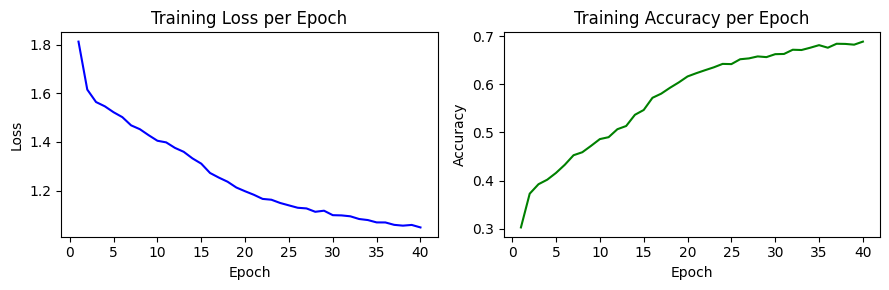

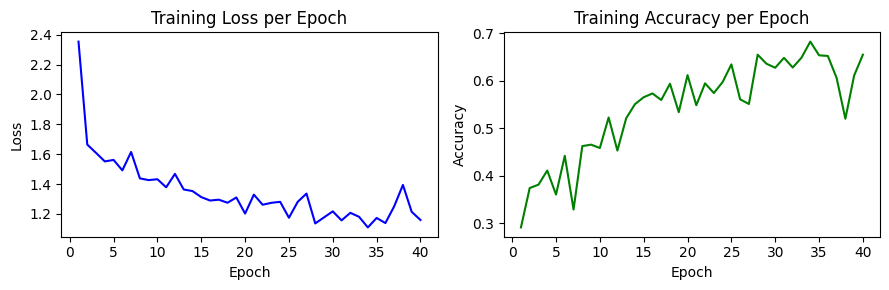

In [ ]:
# plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
# plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

### Visualization 2A: gcn-virtual with CCE

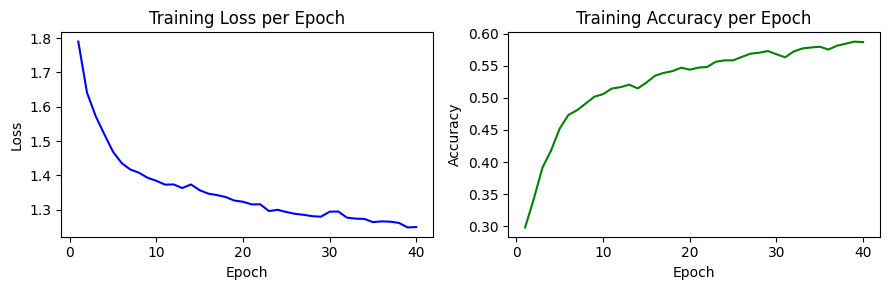

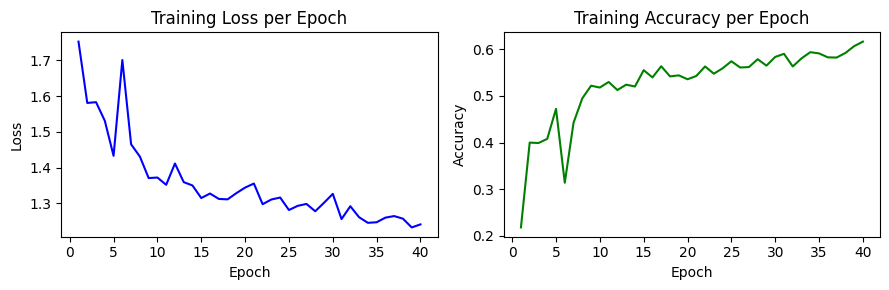

In [ ]:
# plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
# plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

### Visualization 3A: gin-virtual with ELR

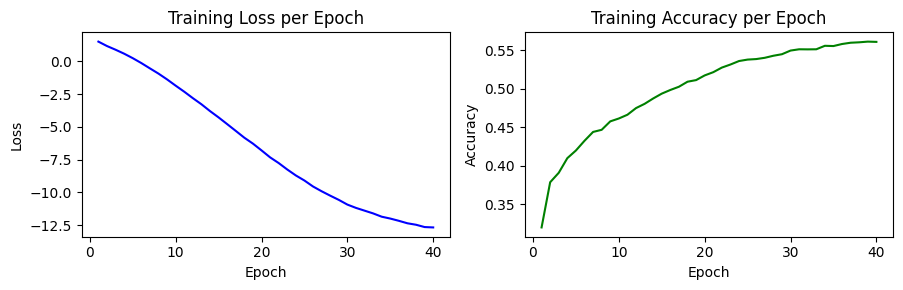

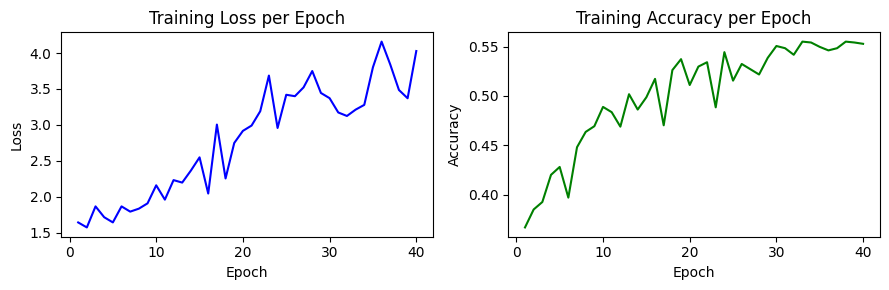

In [ ]:
# plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
# plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

### Visualization 4A: gnc-virtual with ELR

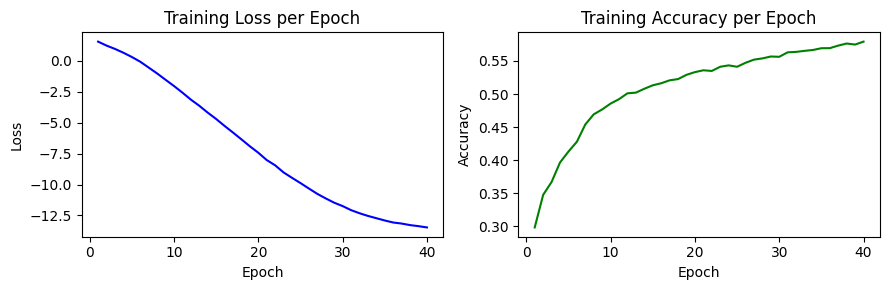

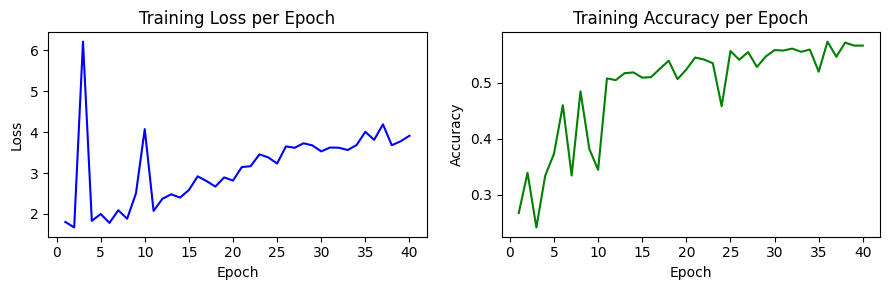

In [ ]:
# plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
# plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

### Visualization 5A: gni-virtual with Label Smoothing CCE

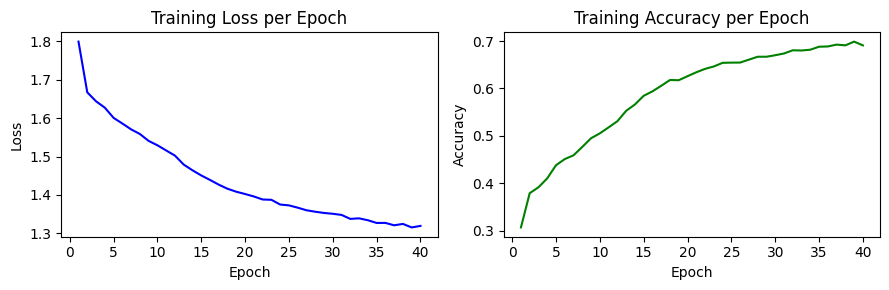

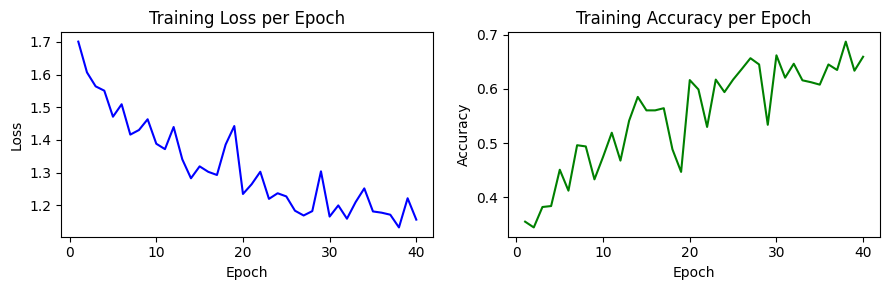

In [ ]:
# train, val = results[:2], results[2:4]
# plot_training_progress(*train, os.path.join(logs_folder, "plots"))
# plot_training_progress(*val, os.path.join(logs_folder, "plotsVal"))

### Visualization 5.1A: gni-virtual with Label Smoothing CCE (60 epochs, 0.3 dropout)

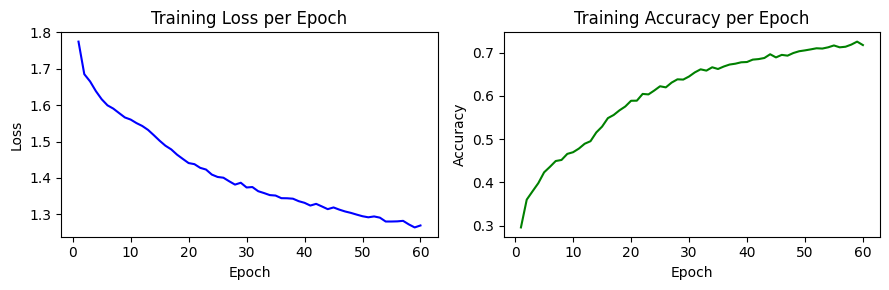

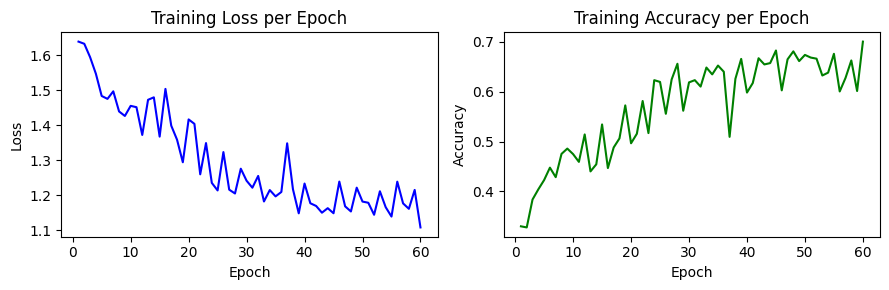

In [ ]:
# train, val = results[:2], results[2:4]
# plot_training_progress(*train, os.path.join(logs_folder, "plots"))
# plot_training_progress(*val, os.path.join(logs_folder, "plotsVal"))

### Visualization 5.2A: gni-virtual with Label Smoothing CCE (60 epochs, 0.35 noise p for LSCCE)

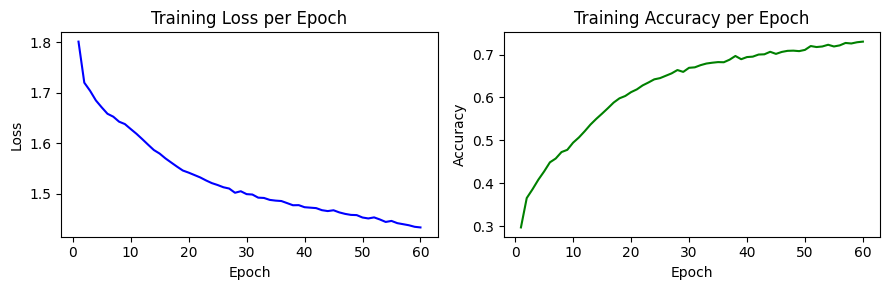

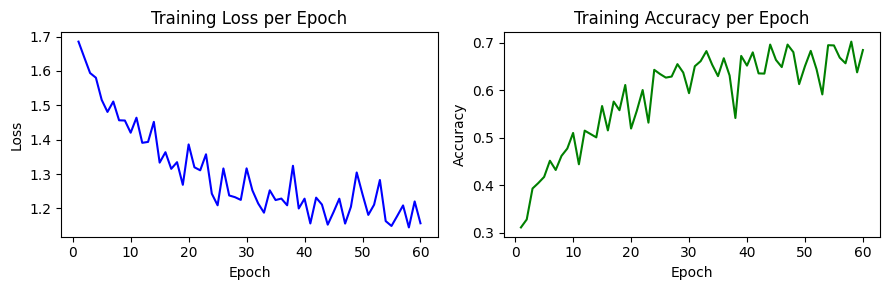

In [ ]:
train, val = results[:2], results[2:4]
plot_training_progress(*train, os.path.join(logs_folder, "plots"))
plot_training_progress(*val, os.path.join(logs_folder, "plotsVal"))

### Visualization 6A: gnc-virtual with Label Smooting CCE

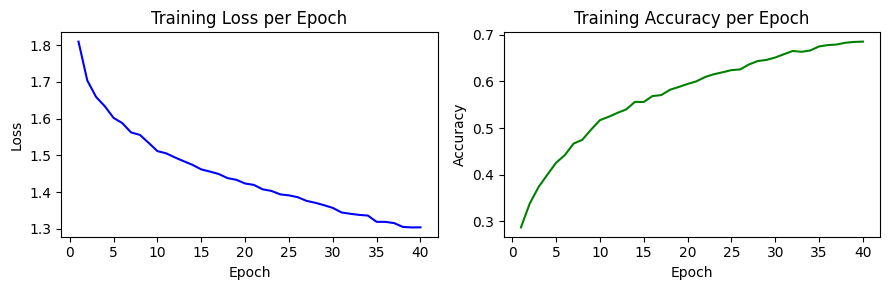

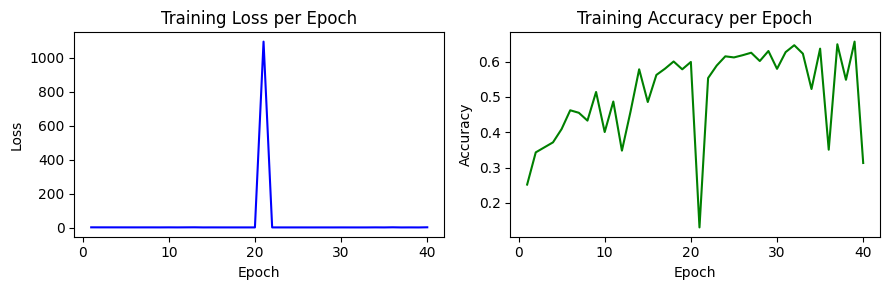

In [ ]:
# train, val = results[:2], results[2:4]
# plot_training_progress(*train, os.path.join(logs_folder, "plots"))
# plot_training_progress(*val, os.path.join(logs_folder, "plotsVal"))

## Dataset A: Basic Co-Teaching algorithm with different GNN and Loss functions


| Try | Loss Function | Model        | Epochs | LR | Batch Size | Dropout | Num Layers | Emb Dim | Params |Ensemble Validation Accuracy |
|:---:|:--------------|:-------------|:------:|:---:|:----------:|:-------:|:----------:|:-------:|:-------------------:|:-------------------:|
| 1 | LS CCE | gnc-virtual | 40 | 0.01 | 32 | 0.1 | 5 | 300 |  $p_{}=0.2$ $\:$ $T_k$=10, $\:$ τ = 0.2| **0.66**|
| 1 | LS CCE | gic-virtual | `60` | `0.001` | 32 | 0.1 | 5 | 300 |  $p_{}=$ `0.35` $\:$ $T_k$=`5`, $\:$ τ = `0.35`| **0.66**|
| 1 | LS CCE | gic-virtual | `60` | 0.01 | 32 | 0.1 | 5 | 300 |  $p_{}=$ `0.35` $\:$ $T_k$=10, $\:$ τ = `0.35`| **0.66**|


### Visualization A: GNC - Virutal Ensemble `noise_prob=0.1`, `noise_rate=0.1`, `ramp_up_epochs=5`, `adam_lr = 0.01`


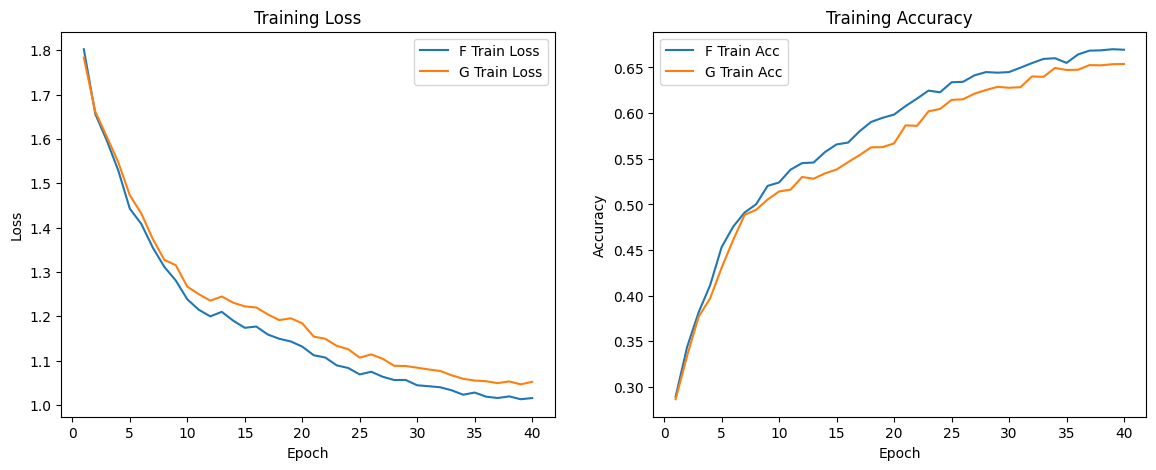

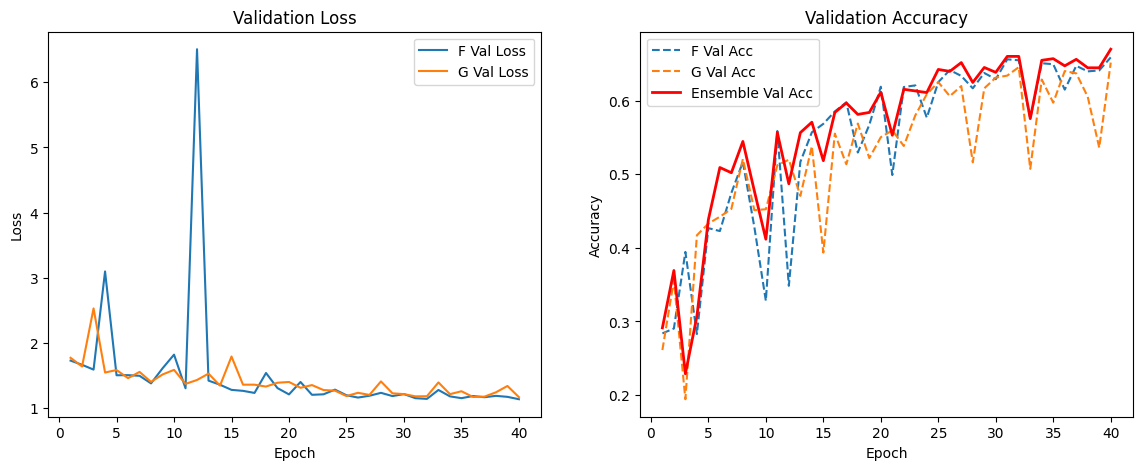

In [ ]:
#  plot_coteaching_results(*results, save_folder='results_plots')

### Visualization A: GIC - Virutal Ensemble: `noise_prob=0.35`, `noise_rate=0.35`, `ramp_up_epochs=5`, `adam_lr = 0.001`

gnn='gin-virtual', drop_ratio=0.1, num_layer=5, emb_dim=300, batch_size=32, epochs=60, baseline_mode=2, noise_prob=0.35, singleGNN=False, simpleCoTeaching=True, noise_rate=0.35, ramp_up_epochs=5

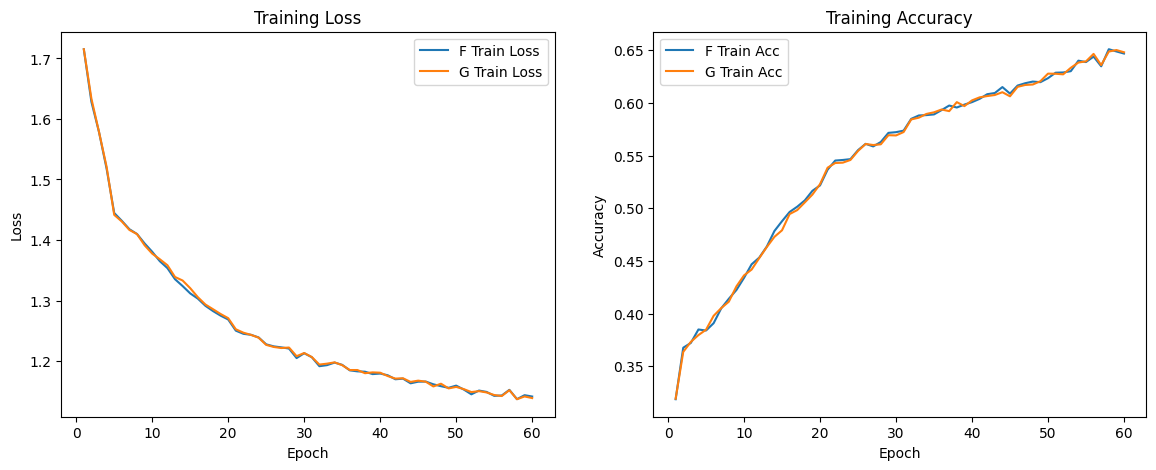

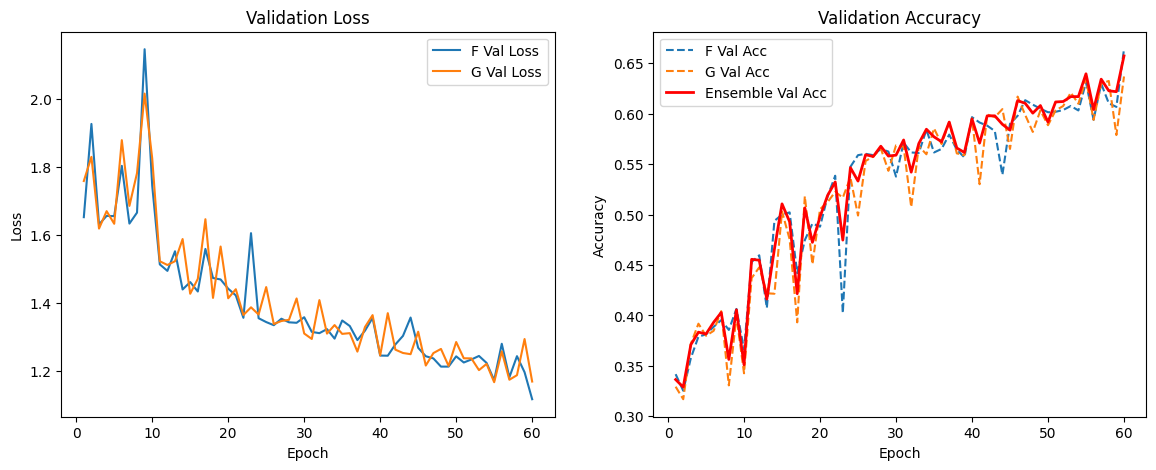

In [ ]:

#  plot_coteaching_results(*results, save_folder='results_plots')

### Visualization A: GIC - Virutal Ensemble: `noise_prob=0.35`, `noise_rate=0.35`, `ramp_up_epochs=10`, `adam_lr=0.01`

gnn='gin-virtual', drop_ratio=0.1, num_layer=5, emb_dim=300, batch_size=32, epochs=60, baseline_mode=2, noise_prob=0.35, singleGNN=False, simpleCoTeaching=True, noise_rate=0.35, ramp_up_epochs=10


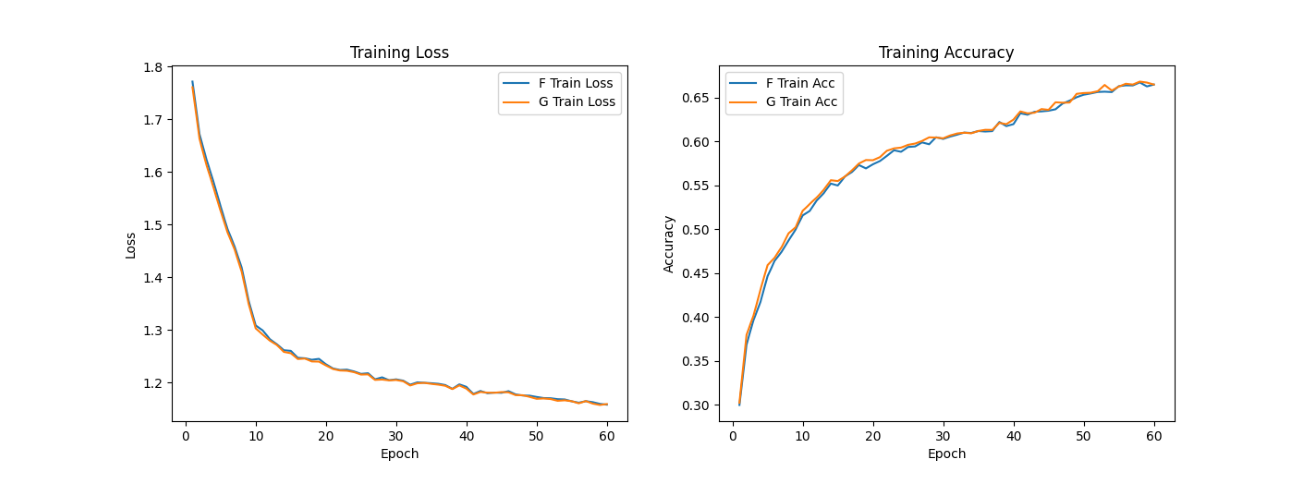

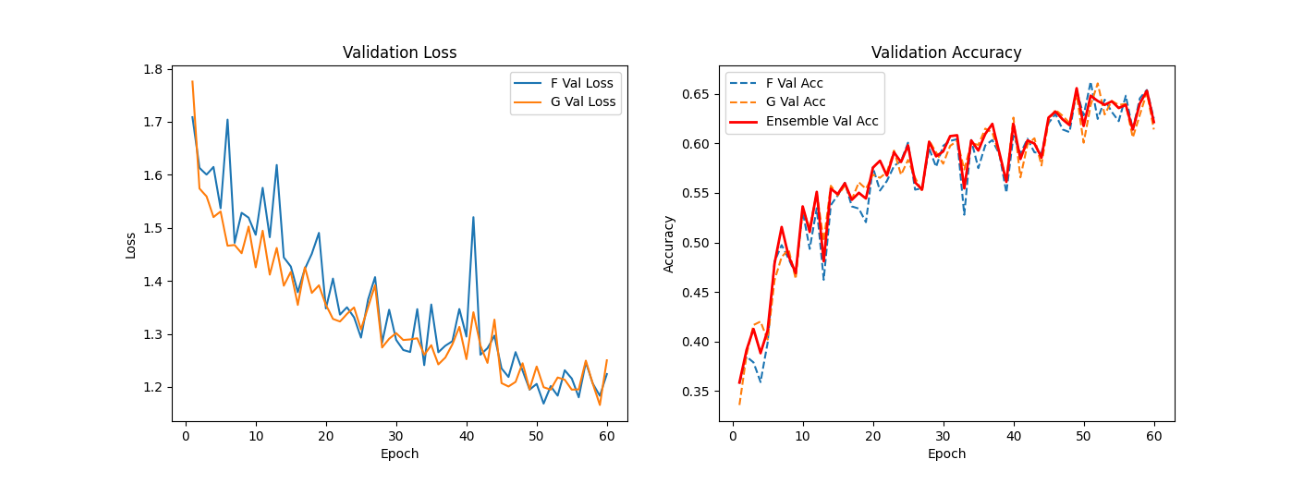

In [ ]:
# # prompt: read a png and display it as if it was a plt
# import matplotlib.pyplot as plt
# from PIL import Image

# plt.figure(figsize=(18, 6))

# img = Image.open('/content/training_metrics.png')
# plt.imshow(img)
# plt.axis('off') # Hide axes
# plt.show()
# plt.figure(figsize=(18, 6))

# img = Image.open('/content/validation_metrics.png')
# plt.imshow(img)
# plt.axis('off') # Hide axes
# plt.show()

## Dataset C: Basic Co-Teaching algorithm with different GNN or Loss functions

### Visualization C: GIN - Virutal Ensemble `noise_prob=0.1`, `noise_rate=0.35`, `ramp_up_epochs=5`, `adam_lr = 0.01`

gnn='gin-virtual', drop_ratio=0.1, num_layer=5, emb_dim=300, batch_size=32, epochs=30, baseline_mode=2, noise_prob=0.35, singleGNN=False, simpleCoTeaching=True, noise_rate=0.35, ramp_up_epochs=5


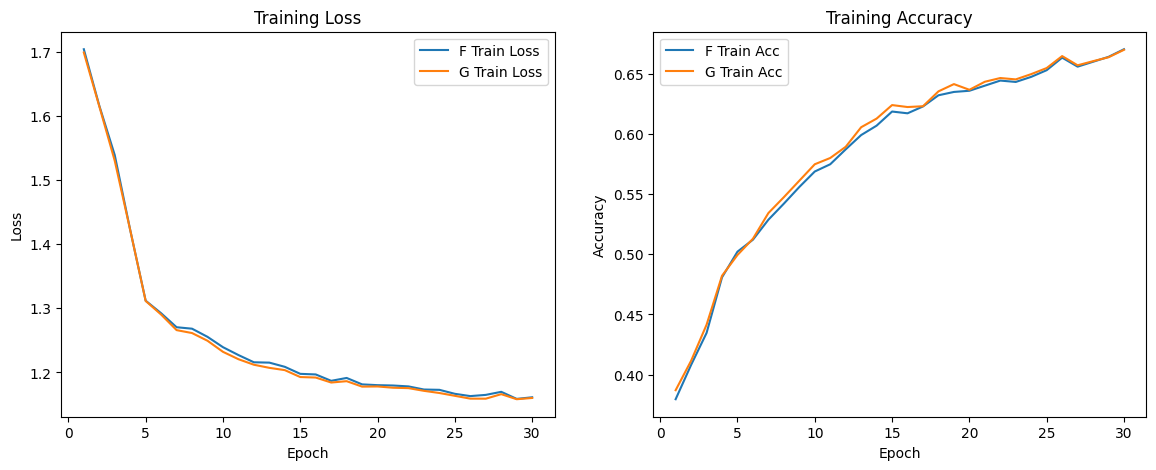

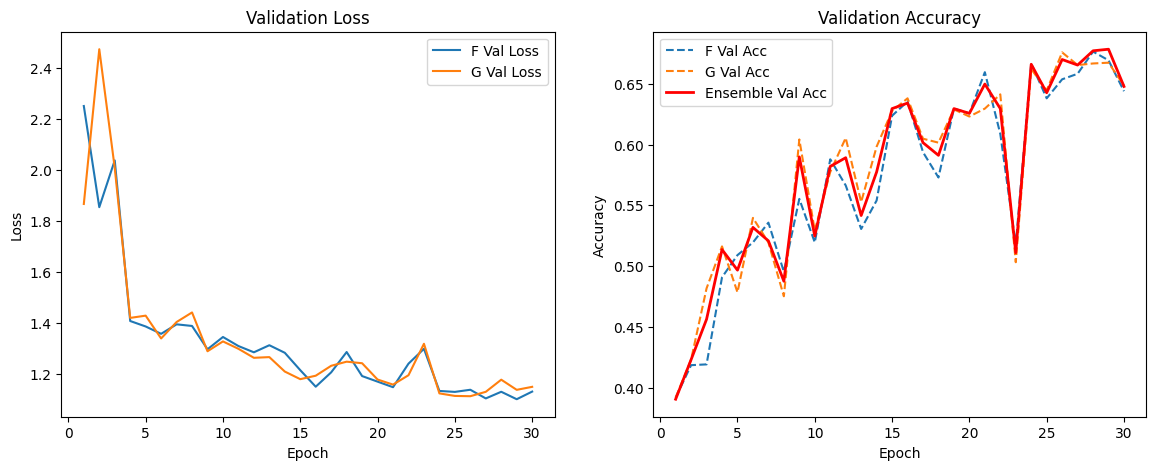

In [ ]:
# plot_coteaching_results(*results, save_folder='results_plots')

In [ ]:
plot_coteaching_results(*results, save_folder='results_plots')

## Dataset D: Co-Teaching with GINEconv implementation. Learning rate increased to 0.05 for ADAM.

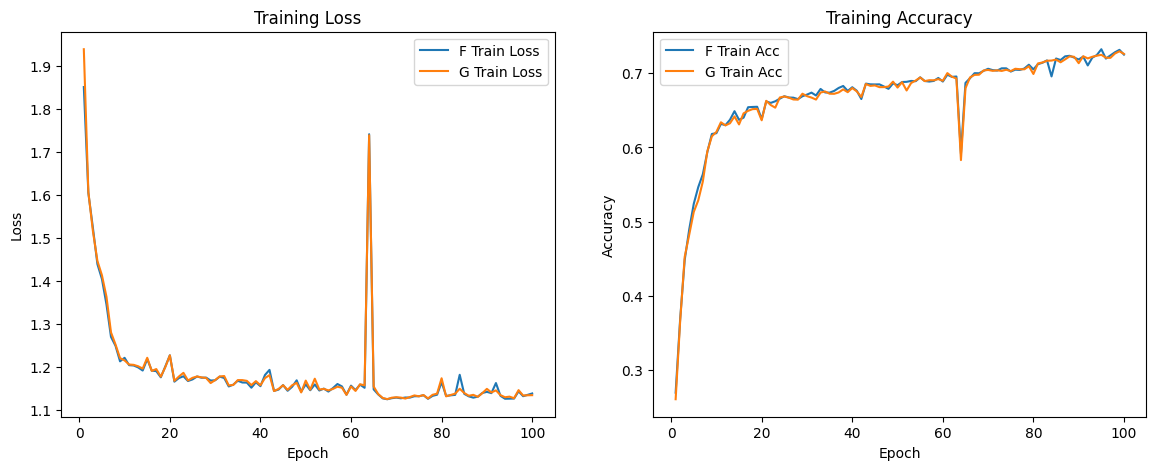

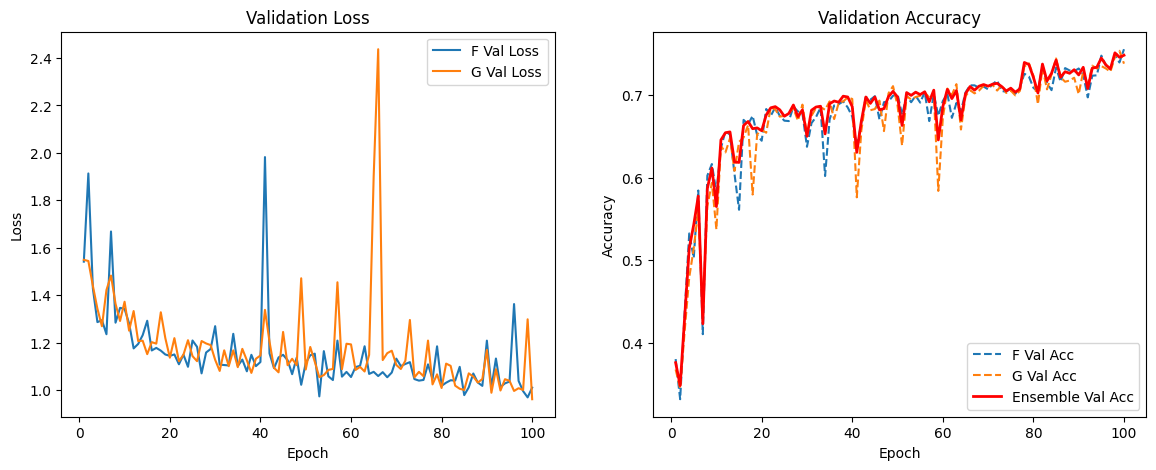

In [ ]:
plot_coteaching_results(*results, save_folder='results_plots')

Namespace(train_path='/content/hackaton/datasets/A/train.json.gz', test_path='/content/hackaton/datasets/A/test.json.gz', num_checkpoints=10, device=0, gnn='gine-virtual', drop_ratio=0.1, num_layer=5, emb_dim=512, batch_size=32, epochs=100, baseline_mode=2, noise_prob=0.35, singleGNN=False, simpleCoTeaching=True, noise_rate=0.35, ramp_up_epochs=7, divide_mix=False, warmup_epochs=1)


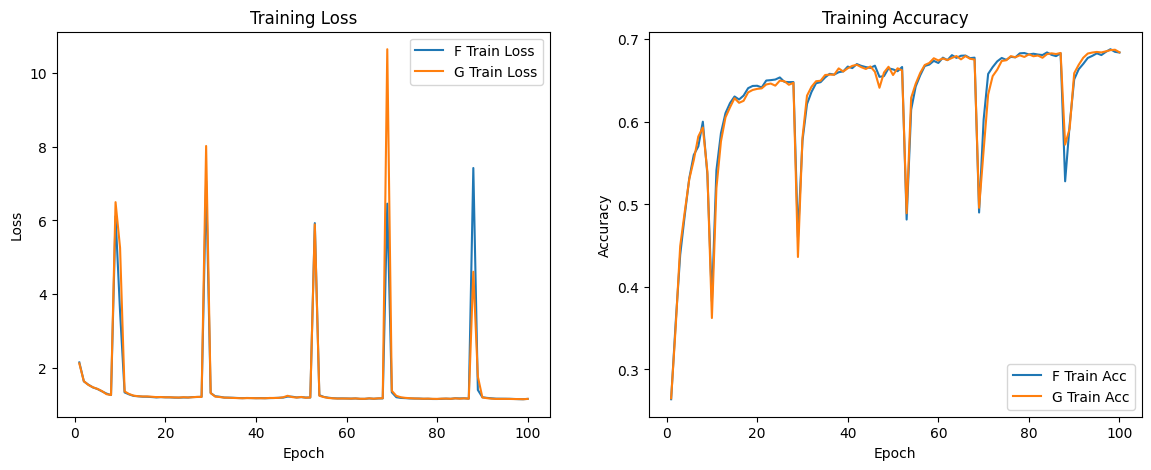

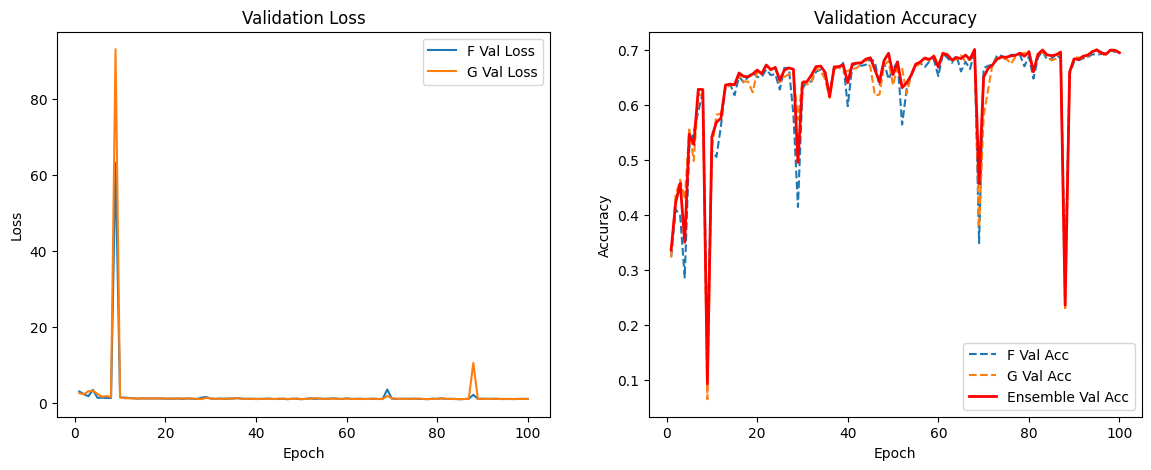

In [ ]:
print(args)
plot_coteaching_results(*results, save_folder='results_plots')